# Введение

In [3]:
import warnings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
RepeatedStratifiedKFold, 
cross_val_score, 
train_test_split, 
GridSearchCV,
cross_val_predict, 
learning_curve, 
validation_curve)
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error,zero_one_loss, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from os.path import join as pjoin
from mlxtend.evaluate import bias_variance_decomp
#sharper plots
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)

warnings.filterwarnings("ignore")

In [4]:
data_path = r"C:\Users\Acer\Desktop\spbu_ml_2025\data" 

## Проклятие размерности

 Проклятие размерности означает, что по мере увеличения количества объектов или измерений в наборе данных объем данных, необходимый для эффективного моделирования взаимосвязи между объектами и целевой переменной, растет экспоненциально.
Чем больше мы добавляем признаков, не увеличивая объем данных, используемых для обучения модели, тем больше увеличивается среднее расстояние между точками в пространстве признаков. Из-за такой разреженности становится гораздо проще найти удобное и совершенное, но не столь оптимальное решение для модели машинного обучения. Следовательно, модель плохо обобщает, что делает прогнозы ненадежными. Это может привести к таким проблемам, как переобучение и снижение точности.

 Чтобы смягчить проклятие размерности, можно использовать такие методы, как выбор признаков, уменьшение размерности и ансамблевые методы.

 Для примера рассмотрим 1000 случайных точек в пространствах размерности от 2 до 50. Построим график, показывающий это свойство.

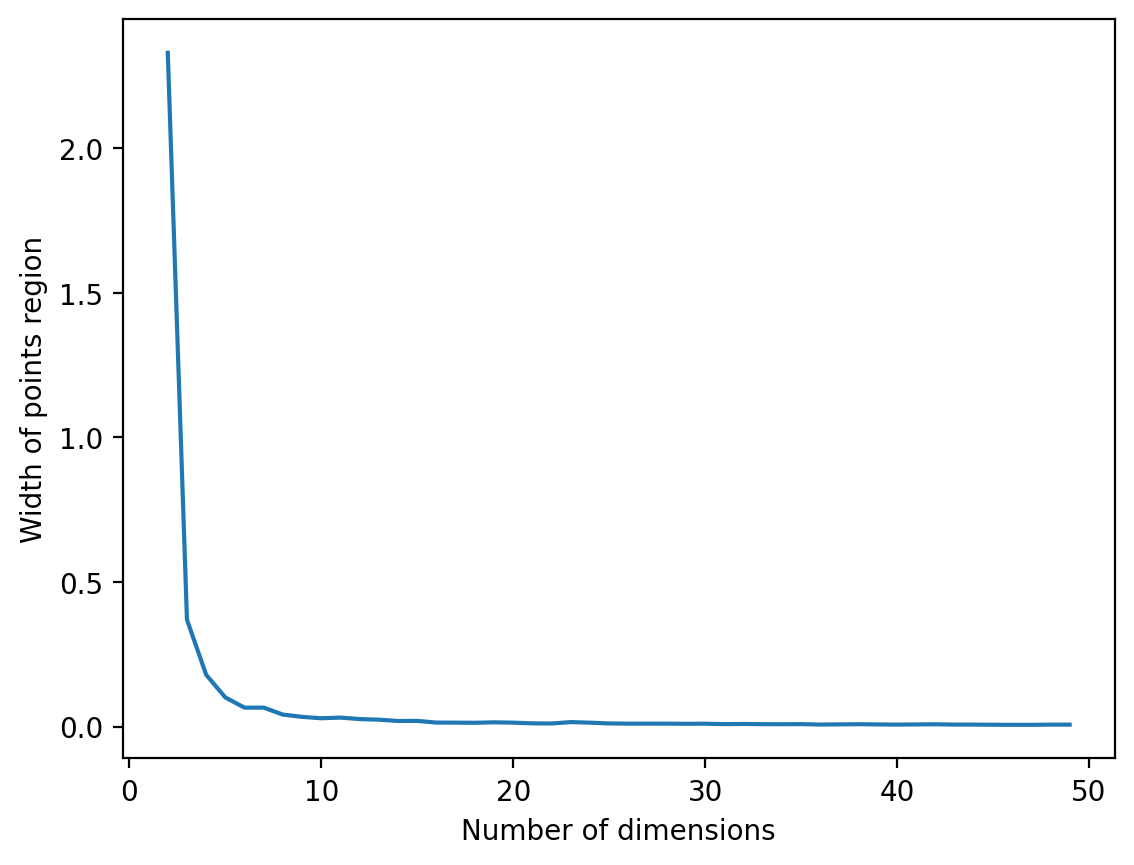

In [5]:
deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = math.log10(mxd-mnd)/mnd # this shows the tightness of points region
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Width of points region')
plt.show()

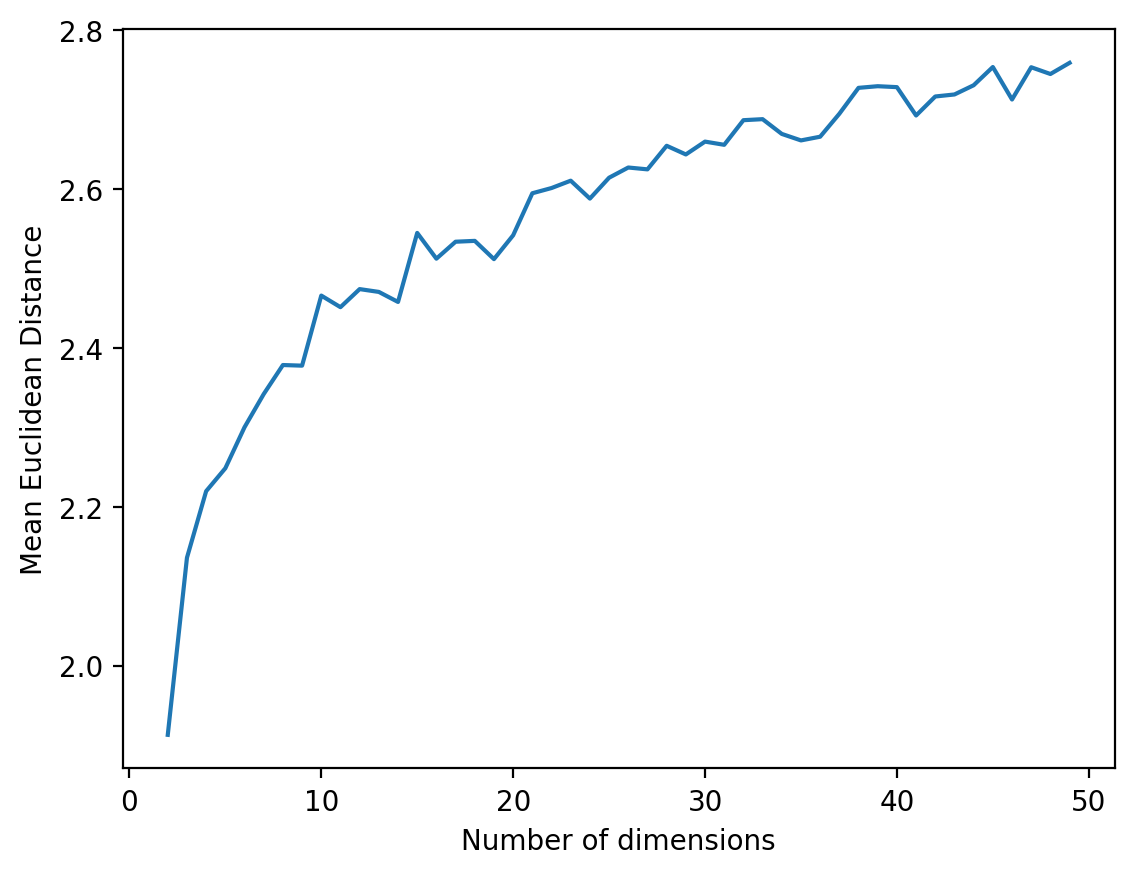

In [6]:
deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mean_distance = np.mean(diffs)
    delta =  math.log10(mean_distance) # YOUR CODE: plot logarithm of mean distance
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Mean Euclidean Distance')
plt.show()

Для того, чтобы уменьшить влияние проклятия размерности, используются разные техники:
 - Feature selection. Выбор наиболее релевантных функций из набора данных может помочь уменьшить размерность и повысить производительность модели.
 - Снижение размерности. Такие методы, как анализ главных компонент (PCA), линейный дискриминантный анализ (LDA) и t-SNE, могут использоваться для уменьшения размерности данных при сохранении наиболее важной информации.
 - Регуляризация. Методы регуляризации, такие как L1 и L2, могут помочь предотвратить переобучение в многомерных наборах данных путем добавления штрафного члена к функции потерь.
 - Ансамблевые методы. Объединение результатов нескольких моделей также может помочь повысить производительность в многомерных наборах данных.
 - Увеличение размера набора обучающих данных также может помочь преодолеть проклятие размерности, однако сбор большего количества данных может занять много времени и стоит дорого.
 - Генерация синтетических данных. Генерацию синтетических данных также можно использовать для увеличения размера набора данных, особенно когда сбор большего количества реальных данных невозможен.

Рассмотрим несколько вариантов решений.

### Feature selection

UCI MAGIC dataset: https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

Телескопами MAGIC в настоящее время управляют около 165 астрофизиков из 24 организаций и консорциумов из 12 стран. MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

В наборе данных хранятся параметры зарегистрированных "фотографий" излучений потоков частиц от этих телескопов. Они делятся на  кванты (фотоны) и адроны (протоны). 
Описание признаков:

- Length: continuous # major axis of ellipse [mm]
- Width: continuous # minor axis of ellipse [mm]
- Size: continuous # 10-log of sum of content of all pixels [in #phot]
- Conc: continuous # ratio of sum of two highest pixels over fSize [ratio]
- Conc1: continuous # ratio of highest pixel over fSize [ratio]
- Asym: continuous # distance from highest pixel to center, projected onto major axis [mm]
- M3Long: continuous # 3rd root of third moment along major axis [mm]
- M3Trans: continuous # 3rd root of third moment along minor axis [mm]
- Alpha: continuous # angle of major axis with vector to origin [deg]
- Dist: continuous # distance from origin to center of ellipse [mm]
- Label: g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 

h = hadron (background): 6688

In [7]:
columns = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv(pjoin(data_path, "magic.txt"),header=None, names=list(columns)+["Label"])

In [8]:
X = data[columns].values
y = 1 * (data['Label'].values == "g")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

**Задание**: Проведите краткий EDA, определите, как выглядят признаки, есть ли пропуски итд

In [10]:
# YOUR CODE
data.describe()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [11]:
data.isnull().sum()

Length     0
Width      0
Size       0
Conc       0
Conc1      0
Asym       0
M3Long     0
M3Trans    0
Alpha      0
Dist       0
Label      0
dtype: int64

In [12]:
data.dtypes

Length     float64
Width      float64
Size       float64
Conc       float64
Conc1      float64
Asym       float64
M3Long     float64
M3Trans    float64
Alpha      float64
Dist       float64
Label       object
dtype: object

In [13]:
#numerical_cols = data.select_dtypes(include=[np.number]).columns
#import seaborn as sns
#
#for col in numerical_cols:
#    plt.figure(figsize=(10, 5))
#    sns.boxplot(x=data[col])
#    plt.title(f'Boxplot for {col}')
#    plt.show()

In [14]:
data.head(5)

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [15]:
# Get all unique values from the 'Label' column
unique_values = data['Label'].unique()

# Print the unique values in the 'Label' column
print("Unique values in 'Label' column:")
print(unique_values)

Unique values in 'Label' column:
['g' 'h']


In [16]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Apply the encoder to the 'Label' column
data['Label'] = encoder.fit_transform(data['Label'])


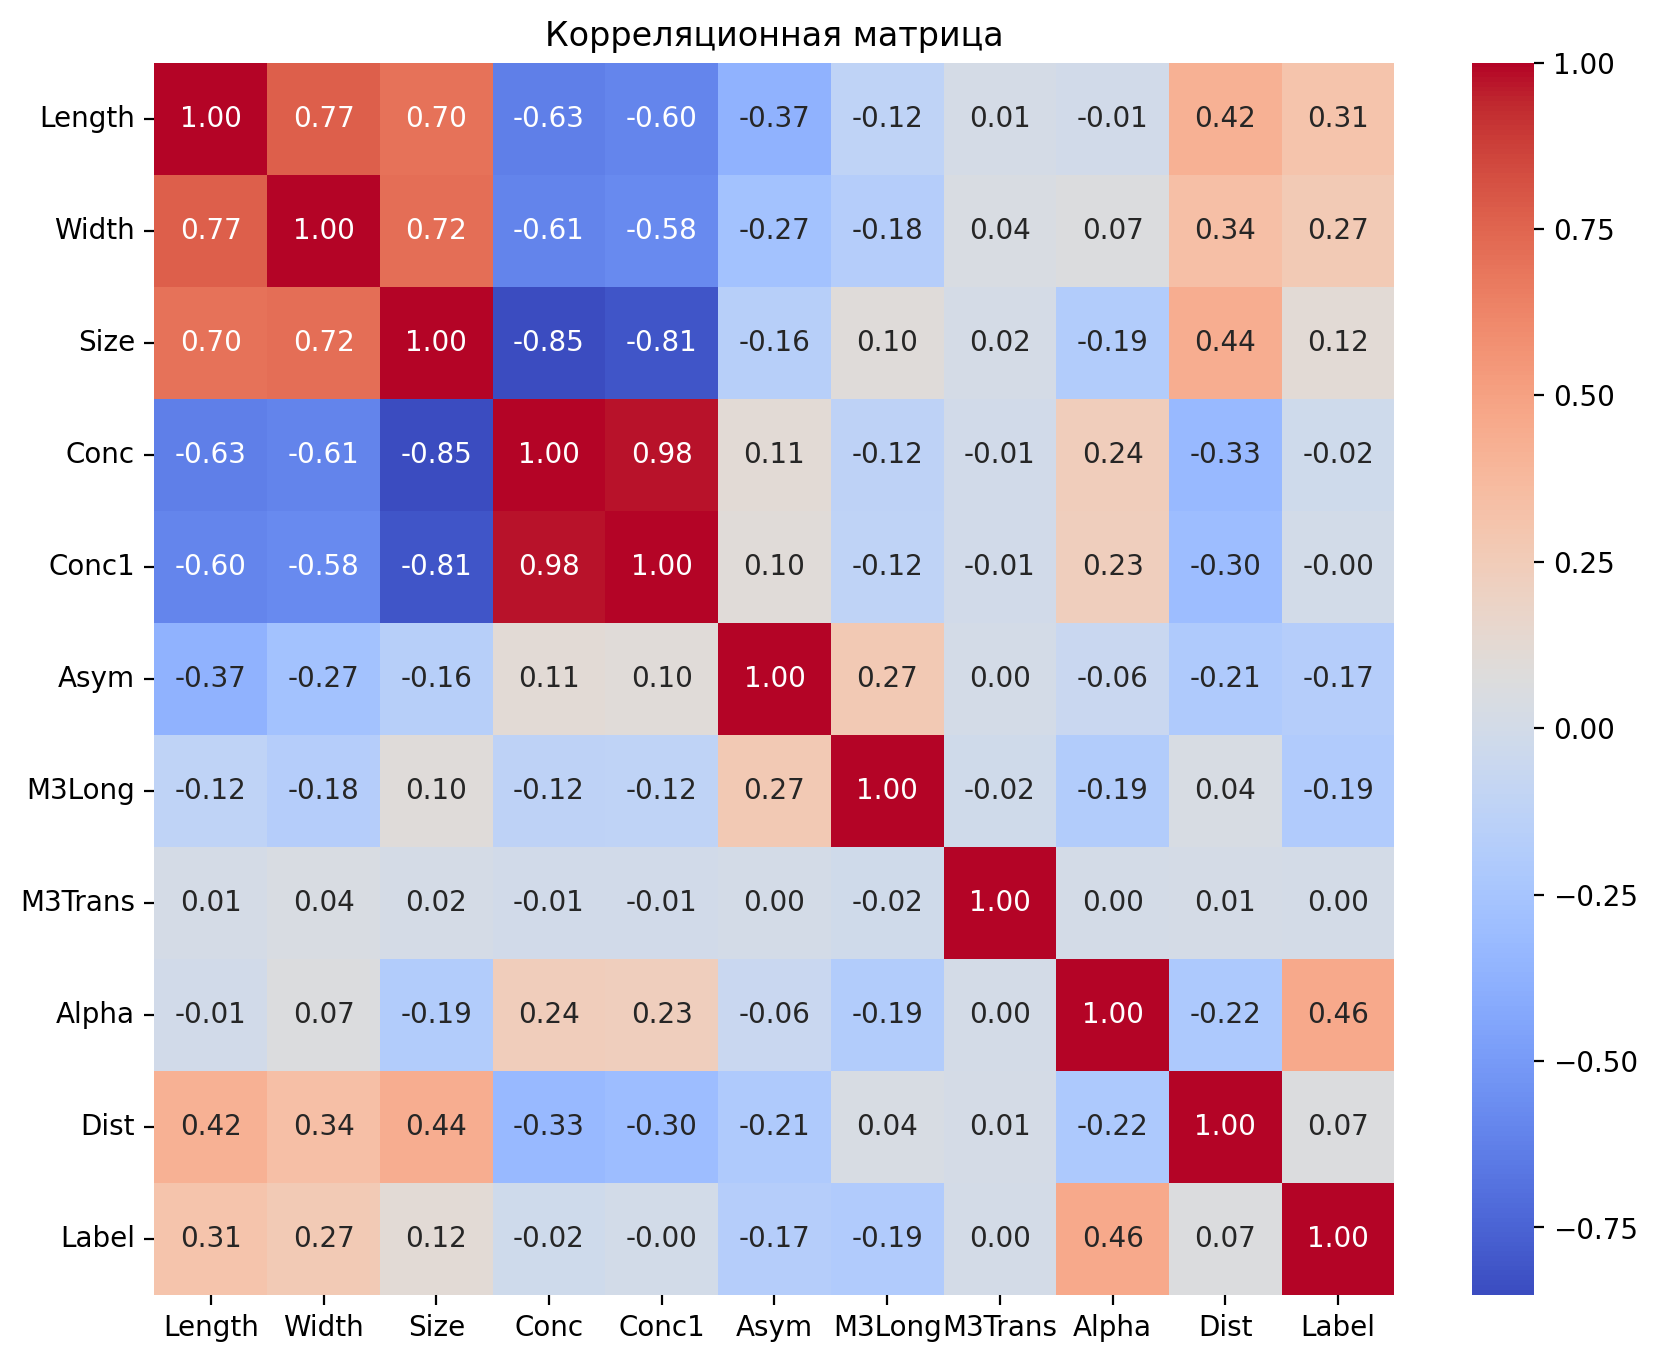

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
Length,1.000000,0.770512,0.702454,-0.630999,-0.598145,-0.368556,-0.119747,0.013389,-0.008777,0.418466,0.307572
Width,0.770512,1.000000,0.717517,-0.609779,-0.581141,-0.266961,-0.176234,0.039744,0.066061,0.336816,0.265596
Size,0.702454,0.717517,1.000000,-0.850850,-0.808835,-0.159863,0.095157,0.015455,-0.186675,0.437041,0.117795
Conc,-0.630999,-0.609779,-0.850850,1.000000,0.976412,0.112272,-0.121899,-0.011294,0.235272,-0.328332,-0.024615
Conc1,-0.598145,-0.581141,-0.808835,0.976412,1.000000,0.100159,-0.118769,-0.010966,0.229799,-0.304625,-0.004797
Asym,-0.368556,-0.266961,-0.159863,0.112272,0.100159,1.000000,0.274045,0.002553,-0.055689,-0.206730,-0.173587
M3Long,-0.119747,-0.176234,0.095157,-0.121899,-0.118769,0.274045,1.000000,-0.017197,-0.186275,0.037025,-0.193409
M3Trans,0.013389,0.039744,0.015455,-0.011294,-0.010966,0.002553,-0.017197,1.000000,0.004659,0.011427,0.003837
Alpha,-0.008777,0.066061,-0.186675,0.235272,0.229799,-0.055689,-0.186275,0.004659,1.000000,-0.220556,0.460979
Dist,0.418466,0.336816,0.437041,-0.328332,-0.304625,-0.206730,0.037025,0.011427,-0.220556,1.000000,0.065203


In [17]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Корреляционная матрица")
plt.show()

correlation_matrix

- Conc и Conc1; Length и Width, Size сильно коррелируют друг с другом.
- Asym, M3Long и M3Trans имеют слабые корреляции с другими переменными.
- Alpha коррелирует с Label

Самый простой способ выбора признаков - Information gain (прирост информации). Прирост информации — это статистика, которая измеряет снижение энтропии (неопределенности) для конкретной функции (таргета) путем деления данных в соответствии с этой характеристикой. Формально, он определен с помощью взаимной информации (I(X , Y) = H(X) – H(X | Y)). Она часто используется в алгоритмах дерева решений, а также имеет другие полезные свойства. Чем выше прирост информации от признака использования признака, тем полезнее он для принятия решений.


In [18]:
X_train

array([[ 74.4411,  31.977 ,   3.4806, ...,  10.4169,   5.3512, 236.404 ],
       [ 22.2607,  13.2452,   2.404 , ...,  13.6282,  27.312 , 217.046 ],
       [ 58.113 ,  24.2392,   2.8351, ...,  26.5948,   3.9914, 334.944 ],
       ...,
       [ 31.7098,  22.6711,   2.8102, ...,  -9.448 ,  24.256 , 249.854 ],
       [ 24.9913,  20.5808,   2.8733, ..., -10.0377,  19.6425, 229.259 ],
       [ 84.684 ,  17.3999,   3.1434, ...,  17.4734,  57.5825, 257.8408]])

In [19]:
# Apply Information Gain
ig = mutual_info_regression(X_train, y_train)

# Create a dictionary of feature importance scores
feature_scores = {}
for i, col in enumerate(list(columns)):
    feature_scores[col ] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print(f"Feature: {feature}, Score: {score}")

Feature: Alpha, Score: 0.12162846042456188
Feature: Width, Score: 0.09445040082440315
Feature: Length, Score: 0.08058367158405844
Feature: M3Long, Score: 0.07613614552215786
Feature: M3Trans, Score: 0.06426505539651295
Feature: Size, Score: 0.043490733560426875
Feature: Asym, Score: 0.043148192400368046
Feature: Conc, Score: 0.027401445258577795
Feature: Conc1, Score: 0.020450755699094714
Feature: Dist, Score: 0.015892641278879793


In [20]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
        
    # Add importance scores as labels on the horizontal bar chart
    for i, v in enumerate(f_imps[sort_inds]):
        plt.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
    plt.show()

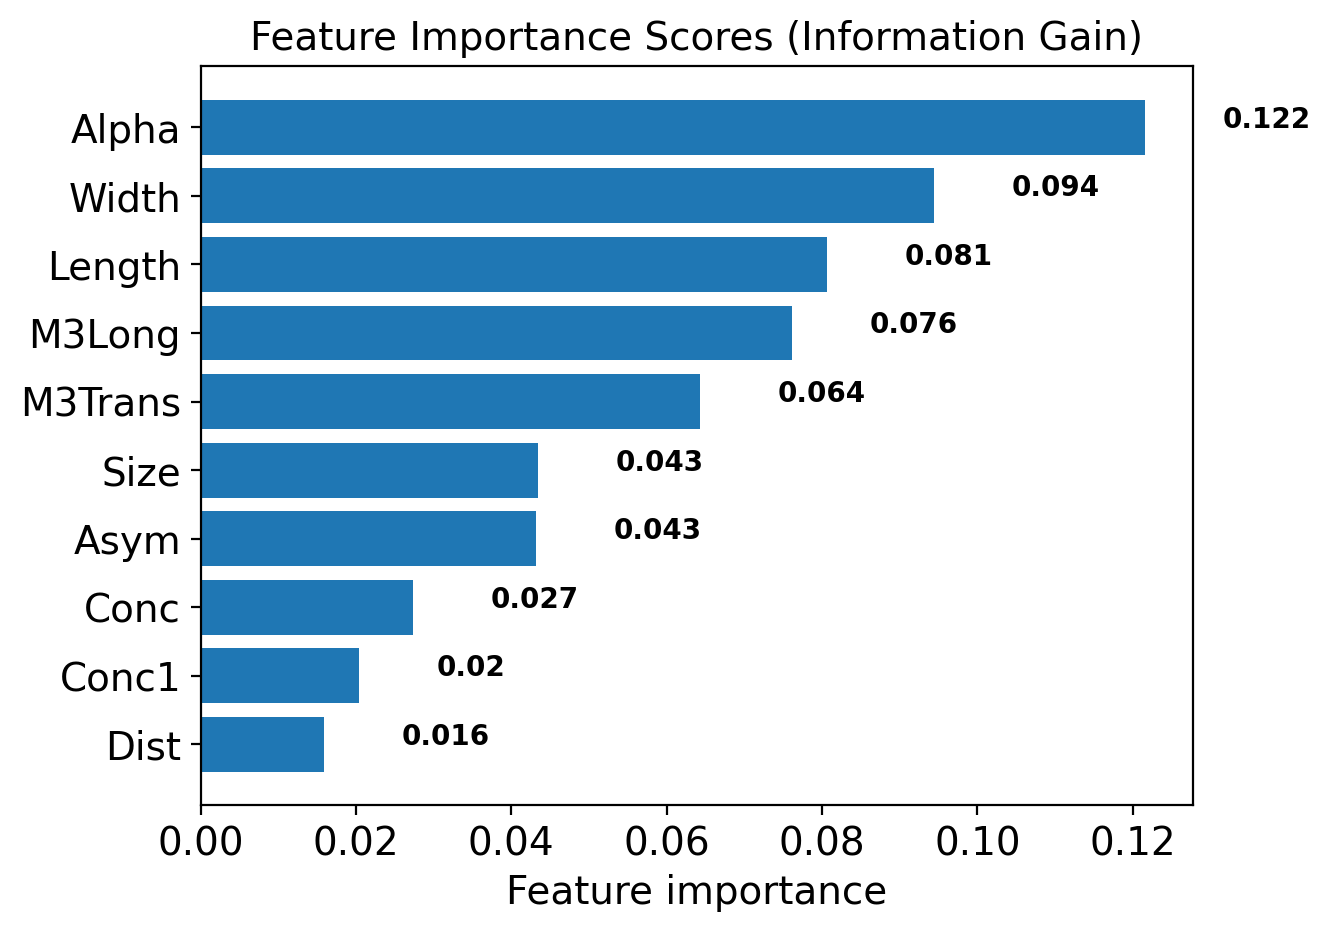

In [21]:
plot_feature_importances(list(feature_scores.values()), list(feature_scores.keys()), title="Feature Importance Scores (Information Gain)")

Вопрос: какие из этих признаков можно считать важными? 

Другой вариант - F test. F-Test выполняет проверку гипотез по моделям X и Y, где X — это модель, созданная только с помощью константы, а Y — это модель, созданная с помощью константы и функции.

Ошибки в обеих моделях сравниваются и проверяется, являются ли различия в ошибках между моделями X и Y значительными или они внесены случайно:

Для каждого признака ошибка
$$E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))$$
преобразуется в F-статистику, после чего рассчитывается уровень значимости признака.

Есть некоторые недостатки использования F-Test для выбора функций. F-Test проверяет и фиксирует только линейные связи между признаками и таргетами. Высококоррелированному признаку присваивается более высокий балл, а менее коррелированному признаку — более низкий балл. Однако даже  сильные нелинейные связи этот тест не выявит.

In [22]:
f_statistic, p_values = f_classif(X_train, y_train)
feature_scores = {}
feature_scores = {}
for i, col in enumerate(list(columns)):
    feature_scores[col] = (f_statistic[i], p_values[i])

# Sort the features by importance score in descending order
sorted_features = sorted(
    feature_scores.items(), key=lambda x: x[1], reverse=True
    )

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print(f"Feature: {feature}, Score: {score[0]}, p-value: {score[1]}")

Feature: Alpha, Score: 3598.8825865588283, p-value: 0.0
Feature: Length, Score: 1436.719050932082, p-value: 1.2023326674804604e-298
Feature: Width, Score: 1027.7857329354808, p-value: 2.6743256315496476e-217
Feature: M3Long, Score: 550.9978582605704, p-value: 2.0026838747965496e-119
Feature: Asym, Score: 420.08393989089376, p-value: 6.1043516013500926e-92
Feature: Size, Score: 208.22845160615563, p-value: 7.5462698144895985e-47
Feature: Dist, Score: 64.22418465342753, p-value: 1.2023775293216669e-15
Feature: Conc, Score: 12.064570946889292, p-value: 0.000515524915007528
Feature: Conc1, Score: 1.3535427769611676, p-value: 0.24468057037956897
Feature: M3Trans, Score: 0.07157075566166207, p-value: 0.7890674868440286


**Вопрос**: Какие из столбцов можно считать важными, основываясь на этом тесте? Поясните свой ответ.

**Задание**: 
1) Постройте модель логистической регрессии, используя все признаки из набора.
2) Также постройте модели для вабранных наборов признаков.

In [23]:
X_train

array([[ 74.4411,  31.977 ,   3.4806, ...,  10.4169,   5.3512, 236.404 ],
       [ 22.2607,  13.2452,   2.404 , ...,  13.6282,  27.312 , 217.046 ],
       [ 58.113 ,  24.2392,   2.8351, ...,  26.5948,   3.9914, 334.944 ],
       ...,
       [ 31.7098,  22.6711,   2.8102, ...,  -9.448 ,  24.256 , 249.854 ],
       [ 24.9913,  20.5808,   2.8733, ..., -10.0377,  19.6425, 229.259 ],
       [ 84.684 ,  17.3999,   3.1434, ...,  17.4734,  57.5825, 257.8408]])

In [24]:
# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Построение модели логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Оценка модели
y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      2006
           1       0.80      0.90      0.85      3700

    accuracy                           0.79      5706
   macro avg       0.78      0.74      0.75      5706
weighted avg       0.79      0.79      0.78      5706



In [25]:
X_t = np.delete(X, [8,9], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.3, random_state=42)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Построение модели логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Оценка модели
y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.34      0.47      2001
           1       0.73      0.95      0.82      3705

    accuracy                           0.74      5706
   macro avg       0.76      0.64      0.65      5706
weighted avg       0.75      0.74      0.70      5706



In [26]:
def print_feature_names(features, original_feature_names: list | None = None):
    if features is not None:
        feature_names = [original_feature_names[int(f)] for f in features]
        print(f"Selected features: {feature_names}")
    else:
        print(f"Selected features: {fs.get_feature_names_out()}")

def select_features(X_train, y_train, X_test, function, k: int = 5, features: list | None = None):
    fs = SelectKBest(score_func=function, k=k)
    fs.fit(X_train, y_train)
    print_feature_names(fs.get_support(indices=True), ["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist", "Label"])
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [27]:
model = DecisionTreeClassifier()
cross_val_score(
    model, X, y, scoring="accuracy", cv=5
).mean()

np.float64(0.8168243953732913)

In [28]:
results = {"num_features": [], "acc": [], "roc_auc": []}

for i in range(1, len(columns) + 1):  
    results["num_features"].append(i)
    
    # Feature selection
    X_train_fs, X_test_fs, fs = select_features(
        X_train, y_train, X_test, f_classif, k=i, features=list(columns)
    )
    
    model = DecisionTreeClassifier()
    model.fit(X_train_fs, y_train)
    
    yhat = model.predict(X_test_fs)
    probs = model.predict_proba(X_test_fs)[:, 1]
    results["acc"].append(accuracy_score(y_test, yhat))
    results["roc_auc"].append(roc_auc_score(y_test, probs))

results_df = pd.DataFrame(results)
results_df

Selected features: ['Length']
Selected features: ['Length', 'Width']
Selected features: ['Length', 'Width', 'M3Long']
Selected features: ['Length', 'Width', 'Asym', 'M3Long']
Selected features: ['Length', 'Width', 'Size', 'Asym', 'M3Long']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Asym', 'M3Long']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans']


,num_features,acc,roc_auc
0,1,0.621977,0.590342
1,2,0.680161,0.647293
2,3,0.710480,0.684661
3,4,0.714336,0.688319
4,5,0.743077,0.718496
5,6,0.750789,0.727766
6,7,0.750088,0.724354
7,8,0.753417,0.729101
8,9,0.743778,0.718576
9,10,0.750613,0.726138


In [29]:
results

{'num_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'acc': [0.6219768664563617,
  0.6801612337889941,
  0.7104801962846127,
  0.714335786890992,
  0.7430774623203645,
  0.750788643533123,
  0.7500876270592359,
  0.7534174553101998,
  0.7437784787942516,
  0.7506133894146513],
 'roc_auc': [np.float64(0.5903422782535858),
  np.float64(0.6472931550419122),
  np.float64(0.684660503756219),
  np.float64(0.6883189983955391),
  np.float64(0.7184958128223338),
  np.float64(0.7277664811319037),
  np.float64(0.7243536126673504),
  np.float64(0.729101238854257),
  np.float64(0.7185759347047125),
  np.float64(0.7261375385181903)]}

Мы можем также оценить признаки, используя сам классификатор. В случае с деревьями, лесами и бустингами это очень естественно.

Пусть $T(f)$ все ноды, использующие фичу $f$ для разбиения. Tогда, важность фичи $Imp(f)$ of $f$:
    $$Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t),$$
    $$\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c),$$
где $n_{t}$ - число объектов в ноде $t$; $I(t)$ – impurity function (gini, cross-entropy, MSE) в ноде $t$
  
В случае ансамбля важности фичей усредняются между деревьями.

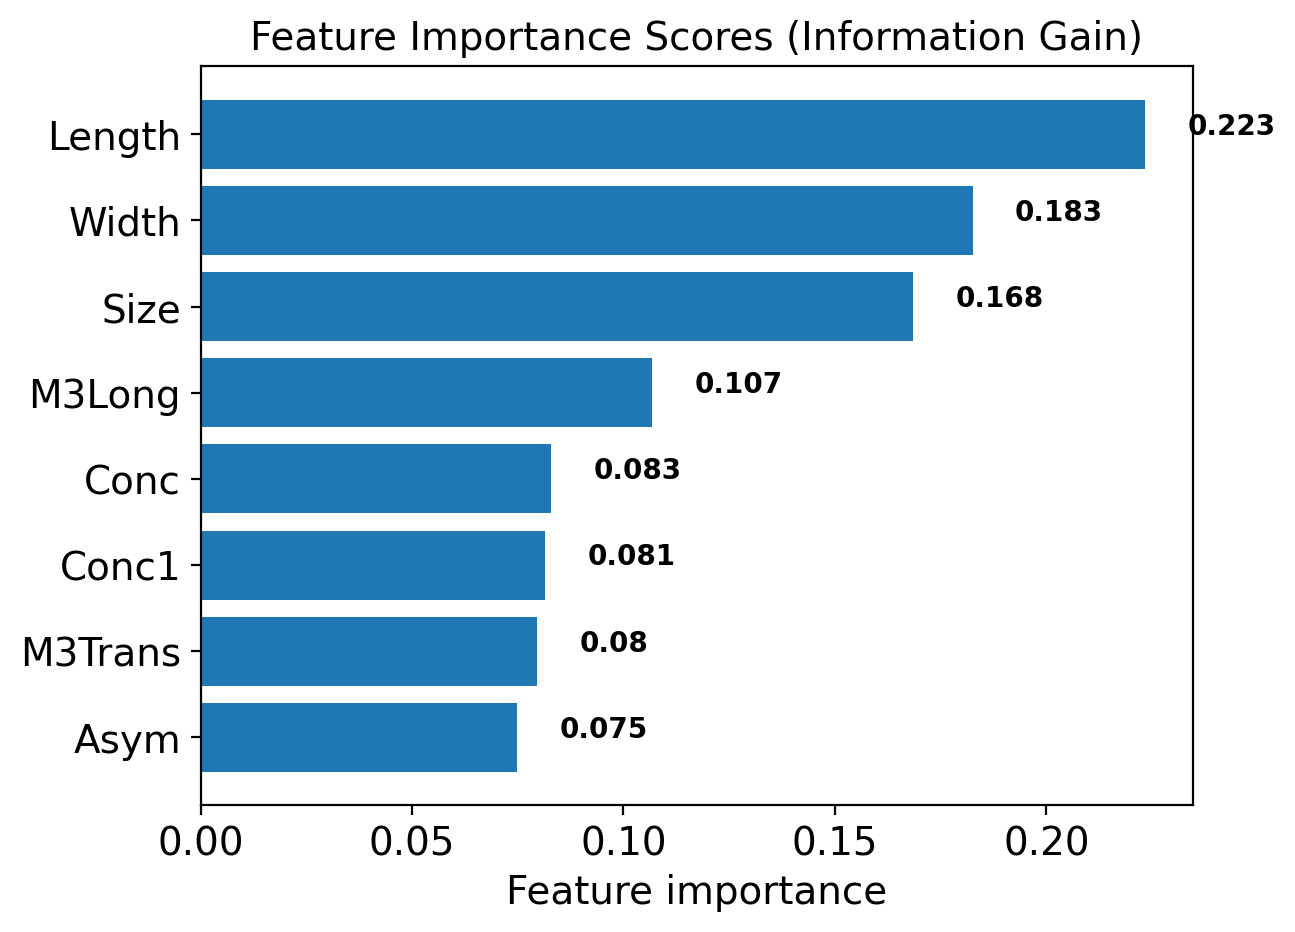

In [30]:
model.fit(X_train, y_train)
plot_feature_importances(model.feature_importances_, columns, title="Feature Importance Scores (Information Gain)")

В случае линейной модели, важность признака тоже можно оценить. В случае отнормализованных признаков, оценкой важности выступает модель соответствующего коэффициента.

**Задание**: Оцените важность признаков, используя линейную модель. 
Подсказка: используйте l2 регуляризацию и <model>.coef_[0] для получения коэффициентов.

In [31]:
def get_feature_imp_with_lin_mod(X_train, y_train, C=1.0):
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_ss = ss.transform(X_train)
    
    model = LogisticRegression(C=C, penalty='l2', solver='lbfgs')
    model.fit(X_train_ss, y_train)
    
    f_imps_lin = np.abs(model.coef_[0]) 
    
    return f_imps_lin

feature_importances = get_feature_imp_with_lin_mod(X_train, y_train)

# Print the result
print("Feature importances:", feature_importances)

Feature importances: [1.07473252 0.54824293 0.07782269 0.2988573  0.46357789 0.00158058
 0.39274088 0.00391387]


Как видно, для разных моделей оценки сильно отличаются. 
Общий метод оценки важности: 
1) Обучите свою модель
2) Рассчитайте метрику качества  $Q_o$  на тестовом наборе
3) Для признака $f$:
     1) Замените значения случайными значениями из того же распределения (выполните случайное перемешивание)
     2) Рассчитайте метрику качества $Q_r$ на тестовом наборе 
     3) Оцените важность признака: $Imp(f) = Q_0 - Q_r$

**Задание**: Реализуйте такой метод, используя линейную модель с регуляризацией.

**Бонусное задание**: Сделайте метрику аргументом, проведите тесты с линейной моделью, деревом решений, случайным лесом, двумя метриками. Постройте таблицу со сравнением.

In [ ]:
def get_feature_imp_general(X_test, y_test, model):
    feature_importances = []
    y_test_pred = model.predict(X_test)
    q_0 = accuracy_score(y_test, y_test_pred)
    for i in range(X_test.shape[1]):

        # do not forget to make a copy of X_test!
        X_test_copy = X_test.copy()

        # shuffle values of the i-th feature
        np.random.shuffle(X_test_copy[:, i])
        
        X_test_copy = np.nan_to_num(X_test_copy)
        y_hat = model.predict(X_test_copy)
        q_r = accuracy_score(y_test, y_hat)

        importance =  q_0 - q_r
        feature_importances.append(importance)

    return np.array(feature_importances)

model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
model.fit(X_train, y_train)

feature_importances = get_feature_imp_general(X_train, y_train, model)

print("Feature importances:", feature_importances)

Feature importances: [ 1.18521857e-01  5.05482950e-02 -8.26197987e-04  1.77257023e-02
  5.18251465e-03 -7.51089079e-05  2.34339793e-02  3.00435632e-04]


In [ ]:
def get_feature_imp_general(X_test, y_test, model, metric):
    feature_importances = []
    y_test_pred = model.predict(X_test)
    q_0 = metric(y_test, y_test_pred)

    for i in range(X_test.shape[1]):
        X_test_copy = X_test.copy()
        np.random.shuffle(X_test_copy[:, i])
        
        X_test_copy = np.nan_to_num(X_test_copy) 
        y_hat = model.predict(X_test_copy)
        q_r = metric(y_test, y_hat)

        importance = q_0 - q_r
        feature_importances.append(importance)

    return np.array(feature_importances)


models = {
    "Logistic Regression": LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

metrics = {
    "Accuracy": accuracy_score,
    "F1 Score": f1_score
}

results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    for metric_name, metric_func in metrics.items():
        feature_importances = get_feature_imp_general(X_test, y_test, model, metric=metric_func)
        mean_importance = np.mean(feature_importances)
        results.append([model_name, metric_name, mean_importance])

df_results = pd.DataFrame(results, columns=["Model", "Metric", "Mean Feature Importance"])
print(df_results)

                 Model    Metric  Mean Feature Importance
0  Logistic Regression  Accuracy                 0.026069
1  Logistic Regression  F1 Score                 0.023992
2        Decision Tree  Accuracy                 0.110563
3        Decision Tree  F1 Score                 0.113865
4        Random Forest  Accuracy                 0.105766
5        Random Forest  F1 Score                 0.106262


Как же перейти от простой оценки важности признаков к поиску такого подмножества, которое приведет к наибольшей точности модели?
Можно использовать рекурсиввный выбор признаков (Recursive feature selection, или RFE).
RFE работает путем поиска подмножества признаков, начиная со всех признаков в наборе и постепенно удаляя самые незначимые, пока не останется желаемое количество.

Это достигается путем подбора модели для оценки, ранжирования признаков по важности, отбрасывания наименее важного признака и повторного обучения модели. Этот процесс повторяется до тех пор, пока не останется заданное количество признаков. Характеристики оцениваются либо с использованием предоставленной модели, либо с использованием статистического метода, такого как f-score или IG.

В sklearn реализован класс трансформера для такого подбора, при этом подюор может быть отделен от основной модели. 

In [ ]:
# scaler = StandardScaler()
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
model = LogisticRegression()
#pipeline = Pipeline(steps=[('sc',scaler),('s',rfe),('m',model)])
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
print("Selected features:", rfe.get_feature_names_out())

# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, y_hat)
print('Accuracy: %.3f' % acc)

Selected features: ['x0' 'x1' 'x2' 'x3' 'x6']
Accuracy: 0.736


In [47]:
scaler = StandardScaler()
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
model = LogisticRegression()
pipeline = Pipeline(steps=[('sc',scaler),('s',rfe),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
print("Selected features:", rfe.get_feature_names_out())

# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, y_hat)
print('Accuracy: %.3f' % acc)

Selected features: ['x0' 'x1' 'x2' 'x3' 'x6']
Accuracy: 0.736


**Задание**: Реализуйте данный метод вручную. Бонусное задание: реализуйте класс трансформера для подбора и/или конфигурируемые метрику и модель.

Number of features: 8, Score: 0.7359
Number of features: 7, Score: 0.7359
Number of features: 6, Score: 0.7357
Number of features: 5, Score: 0.7352
Number of features: 4, Score: 0.7369
Number of features: 3, Score: 0.7285
Number of features: 2, Score: 0.7236


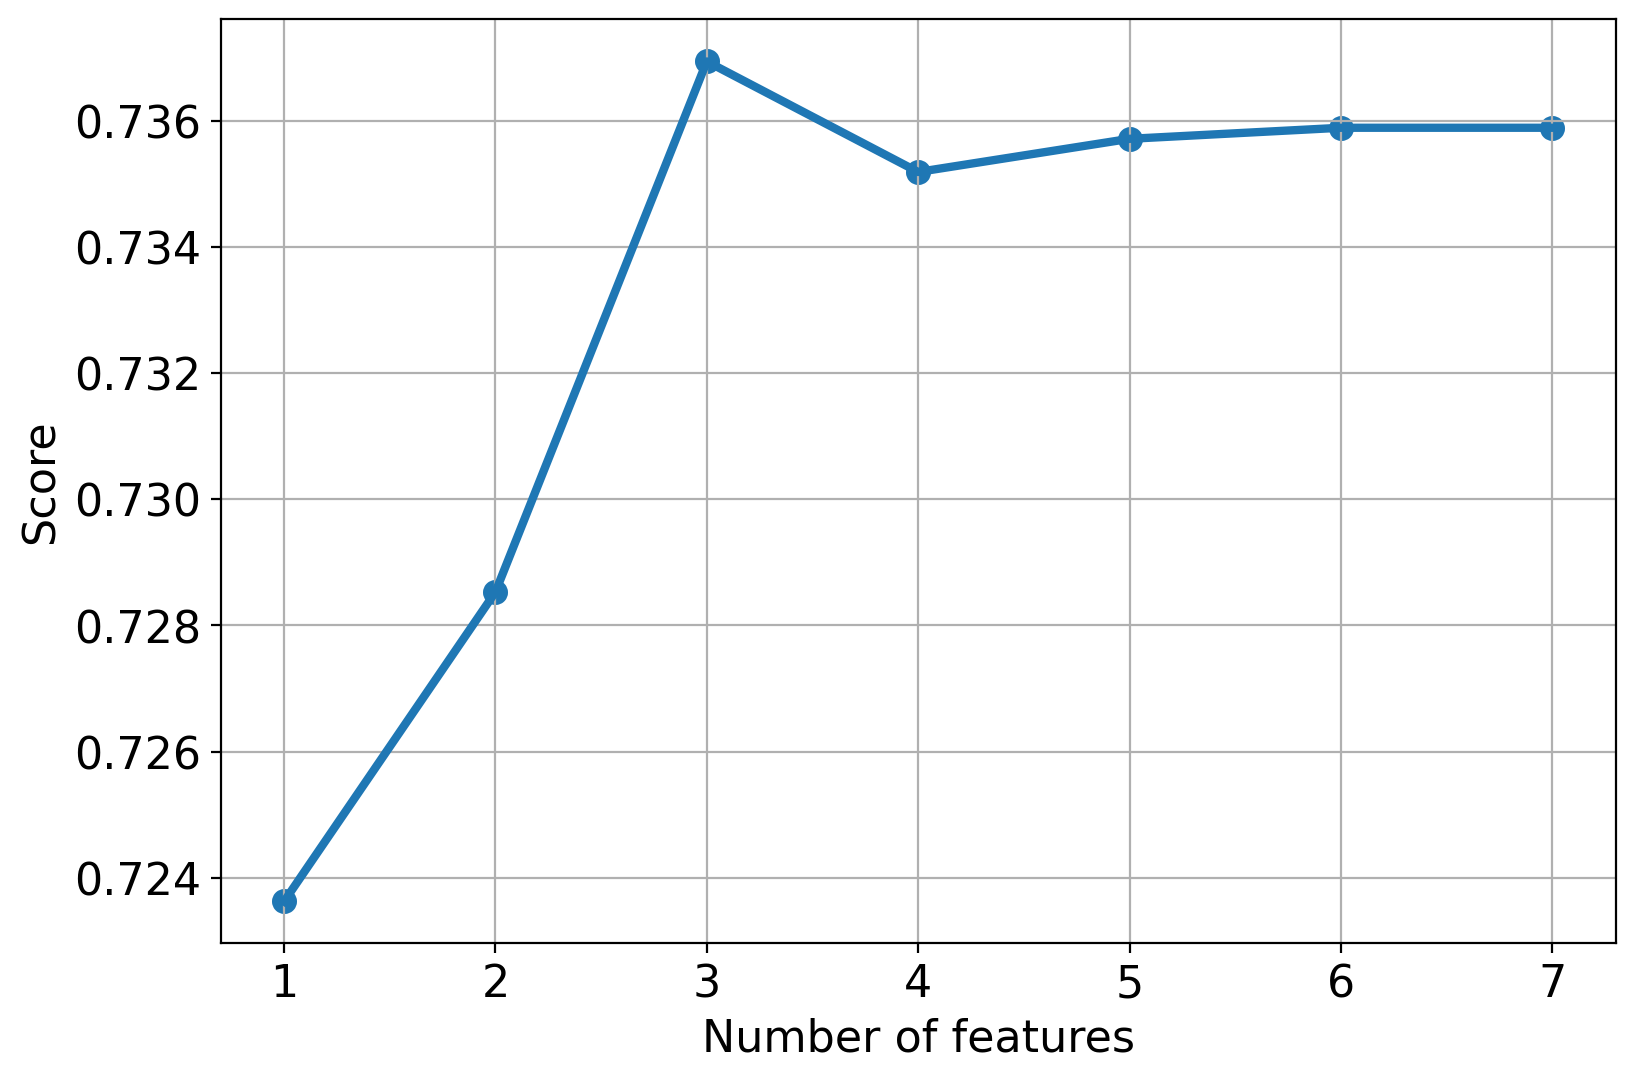

Выбранные признаки: ['Length' 'Alpha' 'Dist']


In [63]:
from sklearn.inspection import permutation_importance

class FeatureSelector:
    def __init__(self, model, metric=accuracy_score):
        self.model = model
        self.metric = metric
        self.scores = []
        self.selected_features = None
    
    def fit(self, X_train, y_train, X_test, y_test, columns):
        X_train_curr = X_train.copy()
        X_test_curr = X_test.copy()
        f_names_curr = np.array(columns)
        
        self.scores = []
        while X_train_curr.shape[1] > 1:
            # Обучаем модель на текущем наборе признаков
            self.model.fit(X_train_curr, y_train)

            # Вычисляем важность признаков
            if hasattr(self.model, 'feature_importances_'):
                importances = self.model.feature_importances_
            else:
                perm_importance = permutation_importance(self.model, X_test_curr, y_test, scoring='accuracy')
                importances = perm_importance.importances_mean
            
            # Делаем предсказание и оцениваем качество модели
            yhat = self.model.predict(X_test_curr)
            score = self.metric(y_test, yhat)
            self.scores.append(score)
            print(f"Number of features: {X_train_curr.shape[1]}, Score: {score:.4f}")
            
            # Удаляем наименее важный признак
            min_idx = np.argmin(importances)
            X_train_curr = np.delete(X_train_curr, min_idx, axis=1)
            X_test_curr = np.delete(X_test_curr, min_idx, axis=1)
            f_names_curr = np.delete(f_names_curr, min_idx)
        
        self.selected_features = f_names_curr
        return self
    
    def plot(self):
        nf = np.arange(len(self.scores), 0, -1)
        plt.figure(figsize=(9, 6))
        plt.plot(nf, self.scores, linewidth=3)
        plt.scatter(nf, self.scores, linewidth=3)
        plt.xlabel("Number of features", size=16)
        plt.ylabel("Score", size=16)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.grid()
        plt.show()

model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
selector = FeatureSelector(model)
selector.fit(X_train, y_train, X_test, y_test, columns)
selector.plot()
print("Выбранные признаки:", selector.selected_features)


Number of features: 8, Score: 0.7359
Number of features: 7, Score: 0.7359
Number of features: 6, Score: 0.7357
Number of features: 5, Score: 0.7352
Number of features: 4, Score: 0.7369
Number of features: 3, Score: 0.7285
Number of features: 2, Score: 0.7236


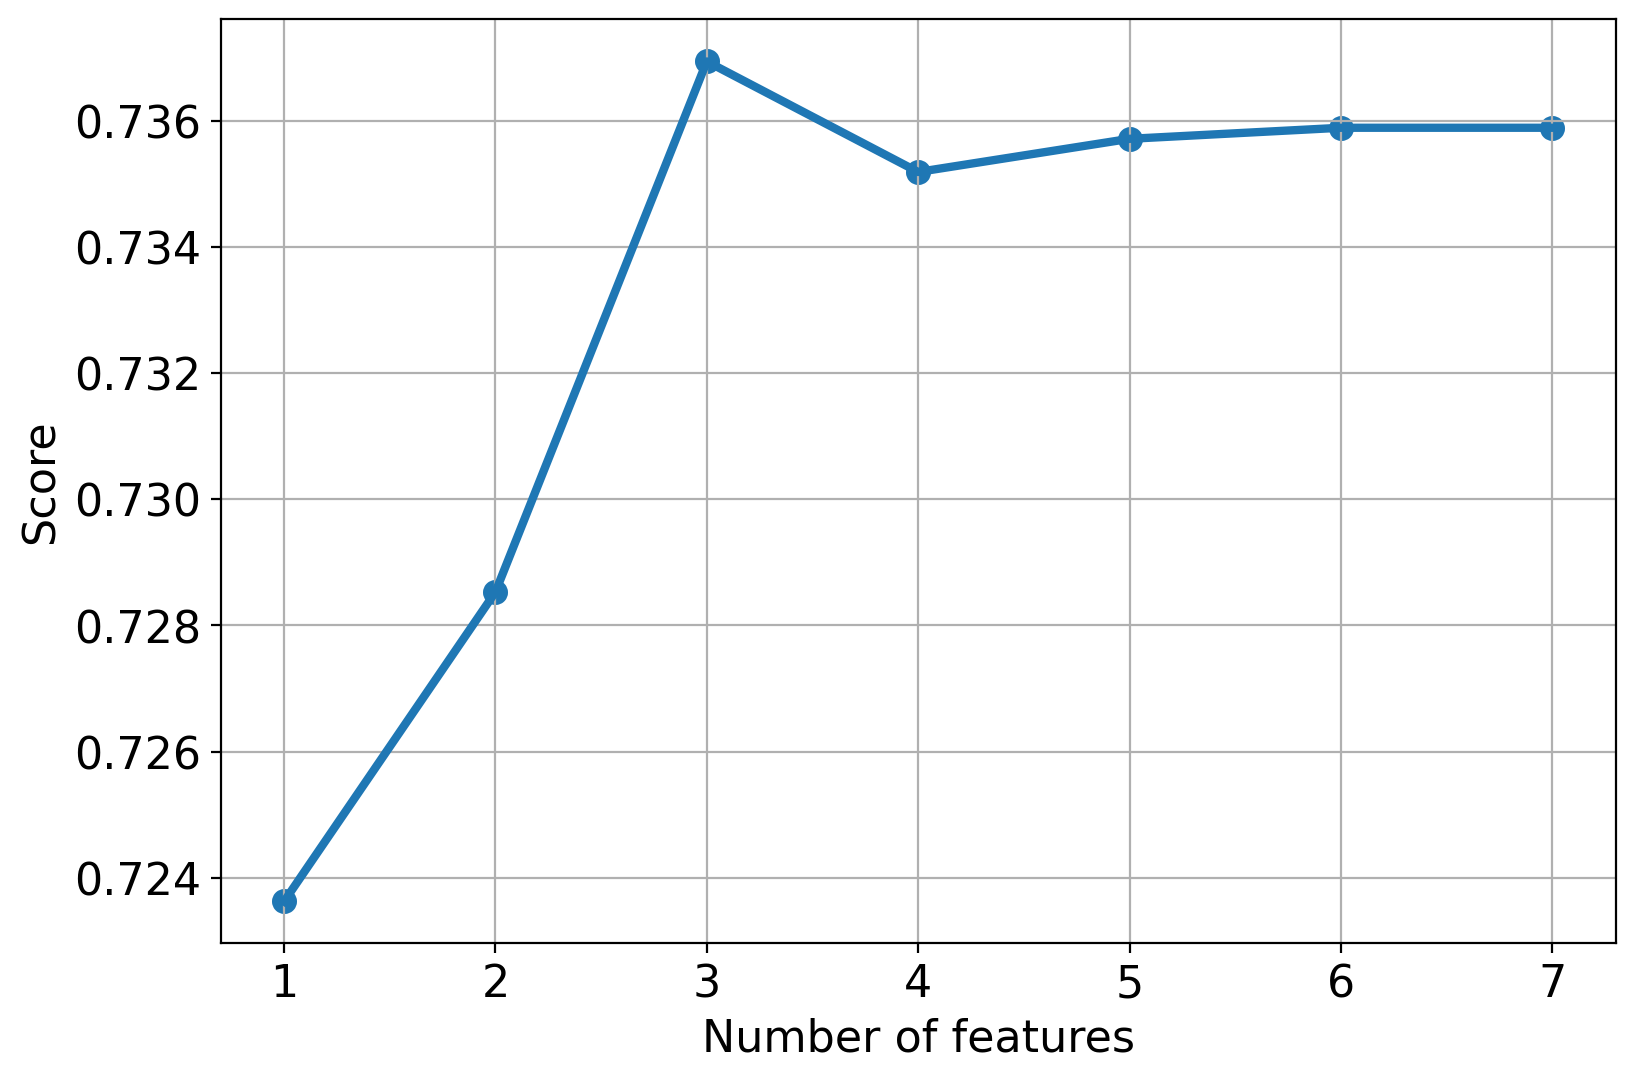

Выбранные признаки: ['Length' 'Alpha' 'Dist']


In [66]:
def find_best_features_set(X_train, y_train, X_test, y_test, model, columns):
    X_train_curr = X_train.copy()
    X_test_curr = X_test.copy()
    f_names_curr = np.array(columns)
    
    scores = []
    while X_train_curr.shape[1] > 1:
        model.fit(X_train_curr, y_train)
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            perm_importance = permutation_importance(model, X_test_curr, y_test, scoring='accuracy')
            importances = perm_importance.importances_mean
        
        yhat = model.predict(X_test_curr)
        score = accuracy_score(y_test, yhat)
        scores.append(score)
        print(f"Number of features: {X_train_curr.shape[1]}, Score: {score:.4f}")
        
        min_idx = np.argmin(importances)
        X_train_curr = np.delete(X_train_curr, min_idx, axis=1)
        X_test_curr = np.delete(X_test_curr, min_idx, axis=1)
        f_names_curr = np.delete(f_names_curr, min_idx)
    
    return scores, f_names_curr

scores, f_names = find_best_features_set(X_train, y_train, X_test, y_test, model, columns)

# Визуализация
nf = np.arange(1, len(scores) + 1)[::-1]
plt.figure(figsize=(9, 6))
plt.plot(nf, scores, linewidth=3)
plt.scatter(nf, scores, linewidth=3)
plt.xlabel("Number of features", size=16)
plt.ylabel("Score", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
plt.show()

print("Выбранные признаки:", f_names)


### PCA

[Ноутбук Евгения Соколова](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem14_pca_tsne.ipynb)

Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно как-то комбинировать.\n",

__Метод главных компонент__ &mdash; один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи:
1. игнорируется целевая переменная;
2. строится линейная комбинация признаков.
П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить не глядя на ответ.
П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

PCA ищет линейную комбинацию переменных, чтобы мы могли извлечь максимальную дисперсию из них. По завершении этого процесса он удаляет ее и ищет другую линейную комбинацию (фактор), которая дает объяснение максимальной пропорции оставшейся дисперсии, что приводит к ортогональным факторам. Это повторяется столько раз, чтобы достигнуть целевого числа объясненной дисперсии или числа факторов.

### Теория
Кратко вспомним, что делает этот метод.
Пусть $X$ &mdash; матрица объекты-признаки, с нулевым средним каждого признака, а $w$ &mdash; некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию вдоль этого направления):
$$\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w$$
Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$ и процесс повторяется.
   

In [67]:
data_synth = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[4, 0],
         [0, 1]],
    size=1000
)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент. В результате работы PCA из sklearn в dec.components_ будут лежать главные направления (нормированные), а в dec.explained_variance_ — дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

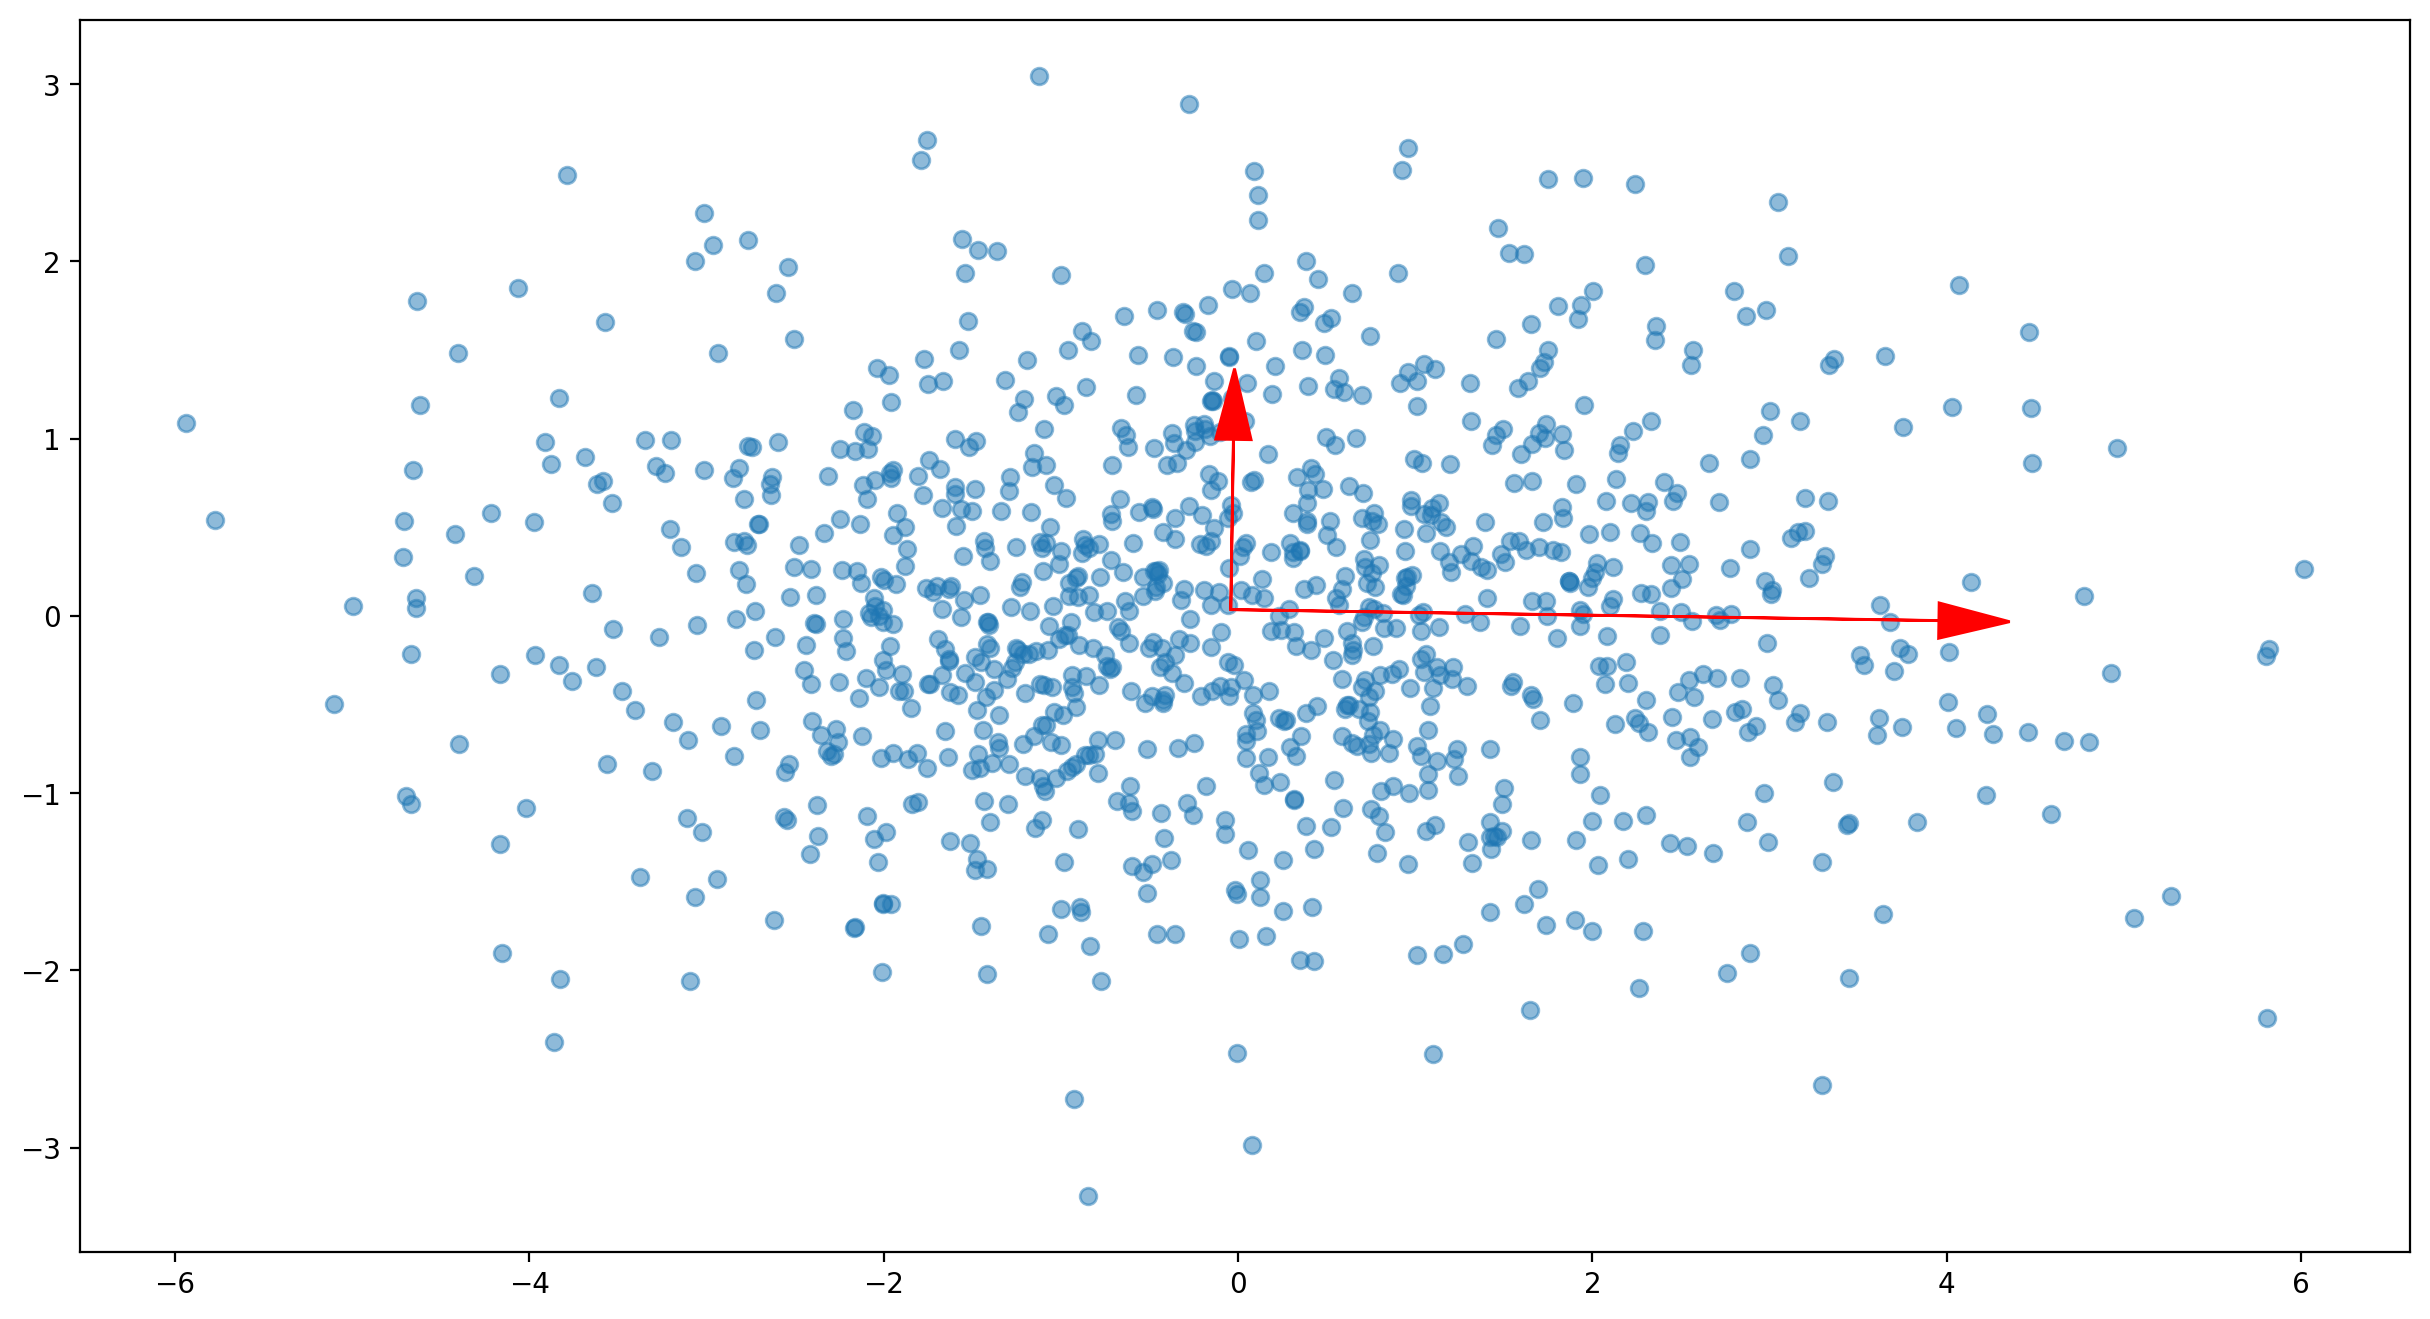

In [68]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)

    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')

    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth)

Видим, что PCA все правильно нашел. Но это, конечно, можно было сделать и просто посчитав дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим, что для PCA это ничего не изменит.

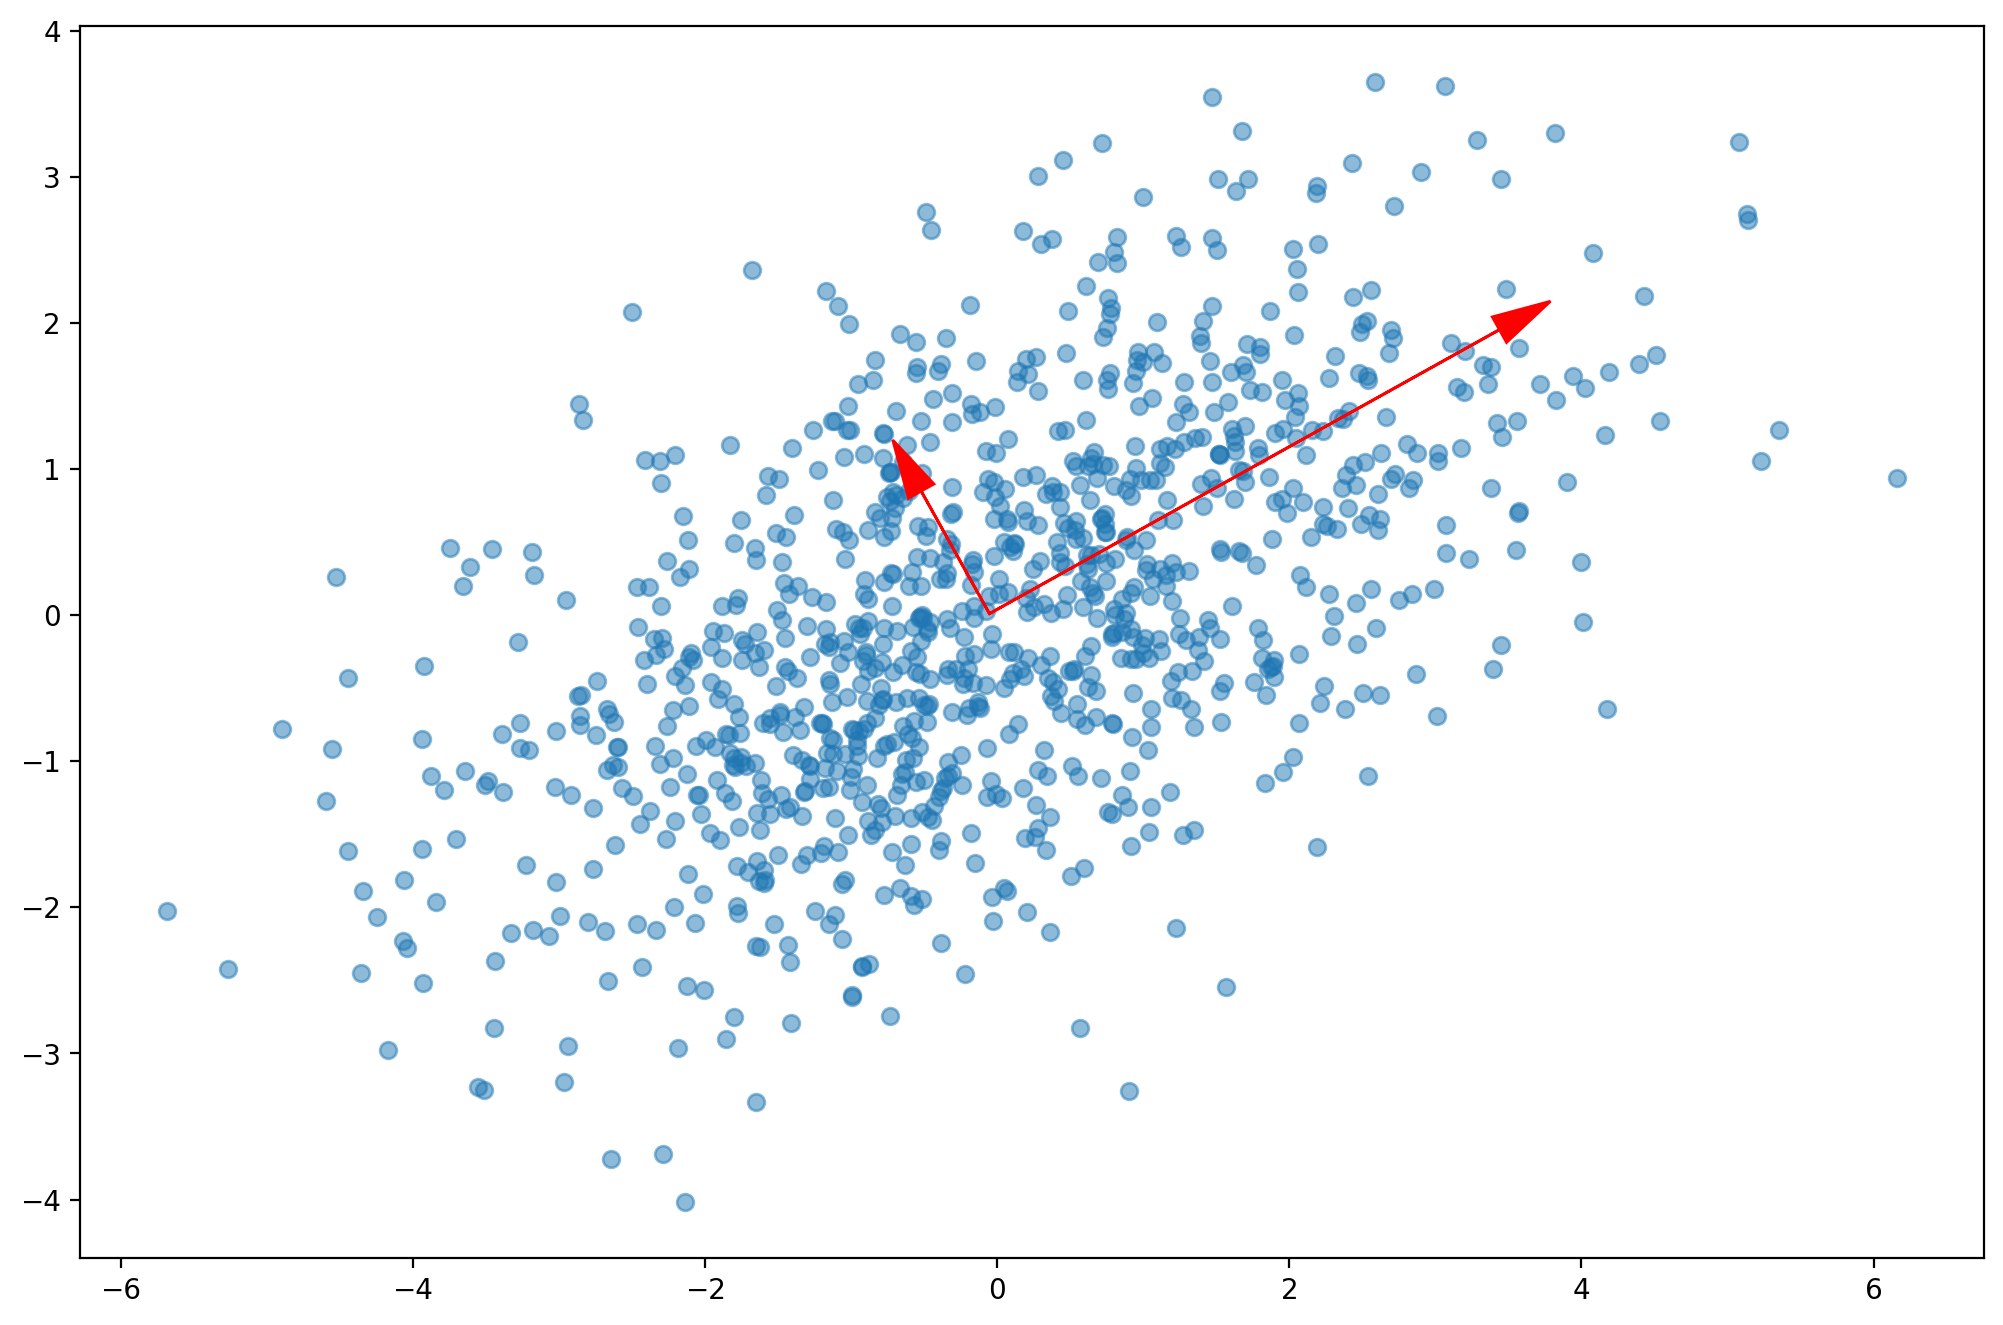

In [69]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки).

Вопрос: почему так произошло?

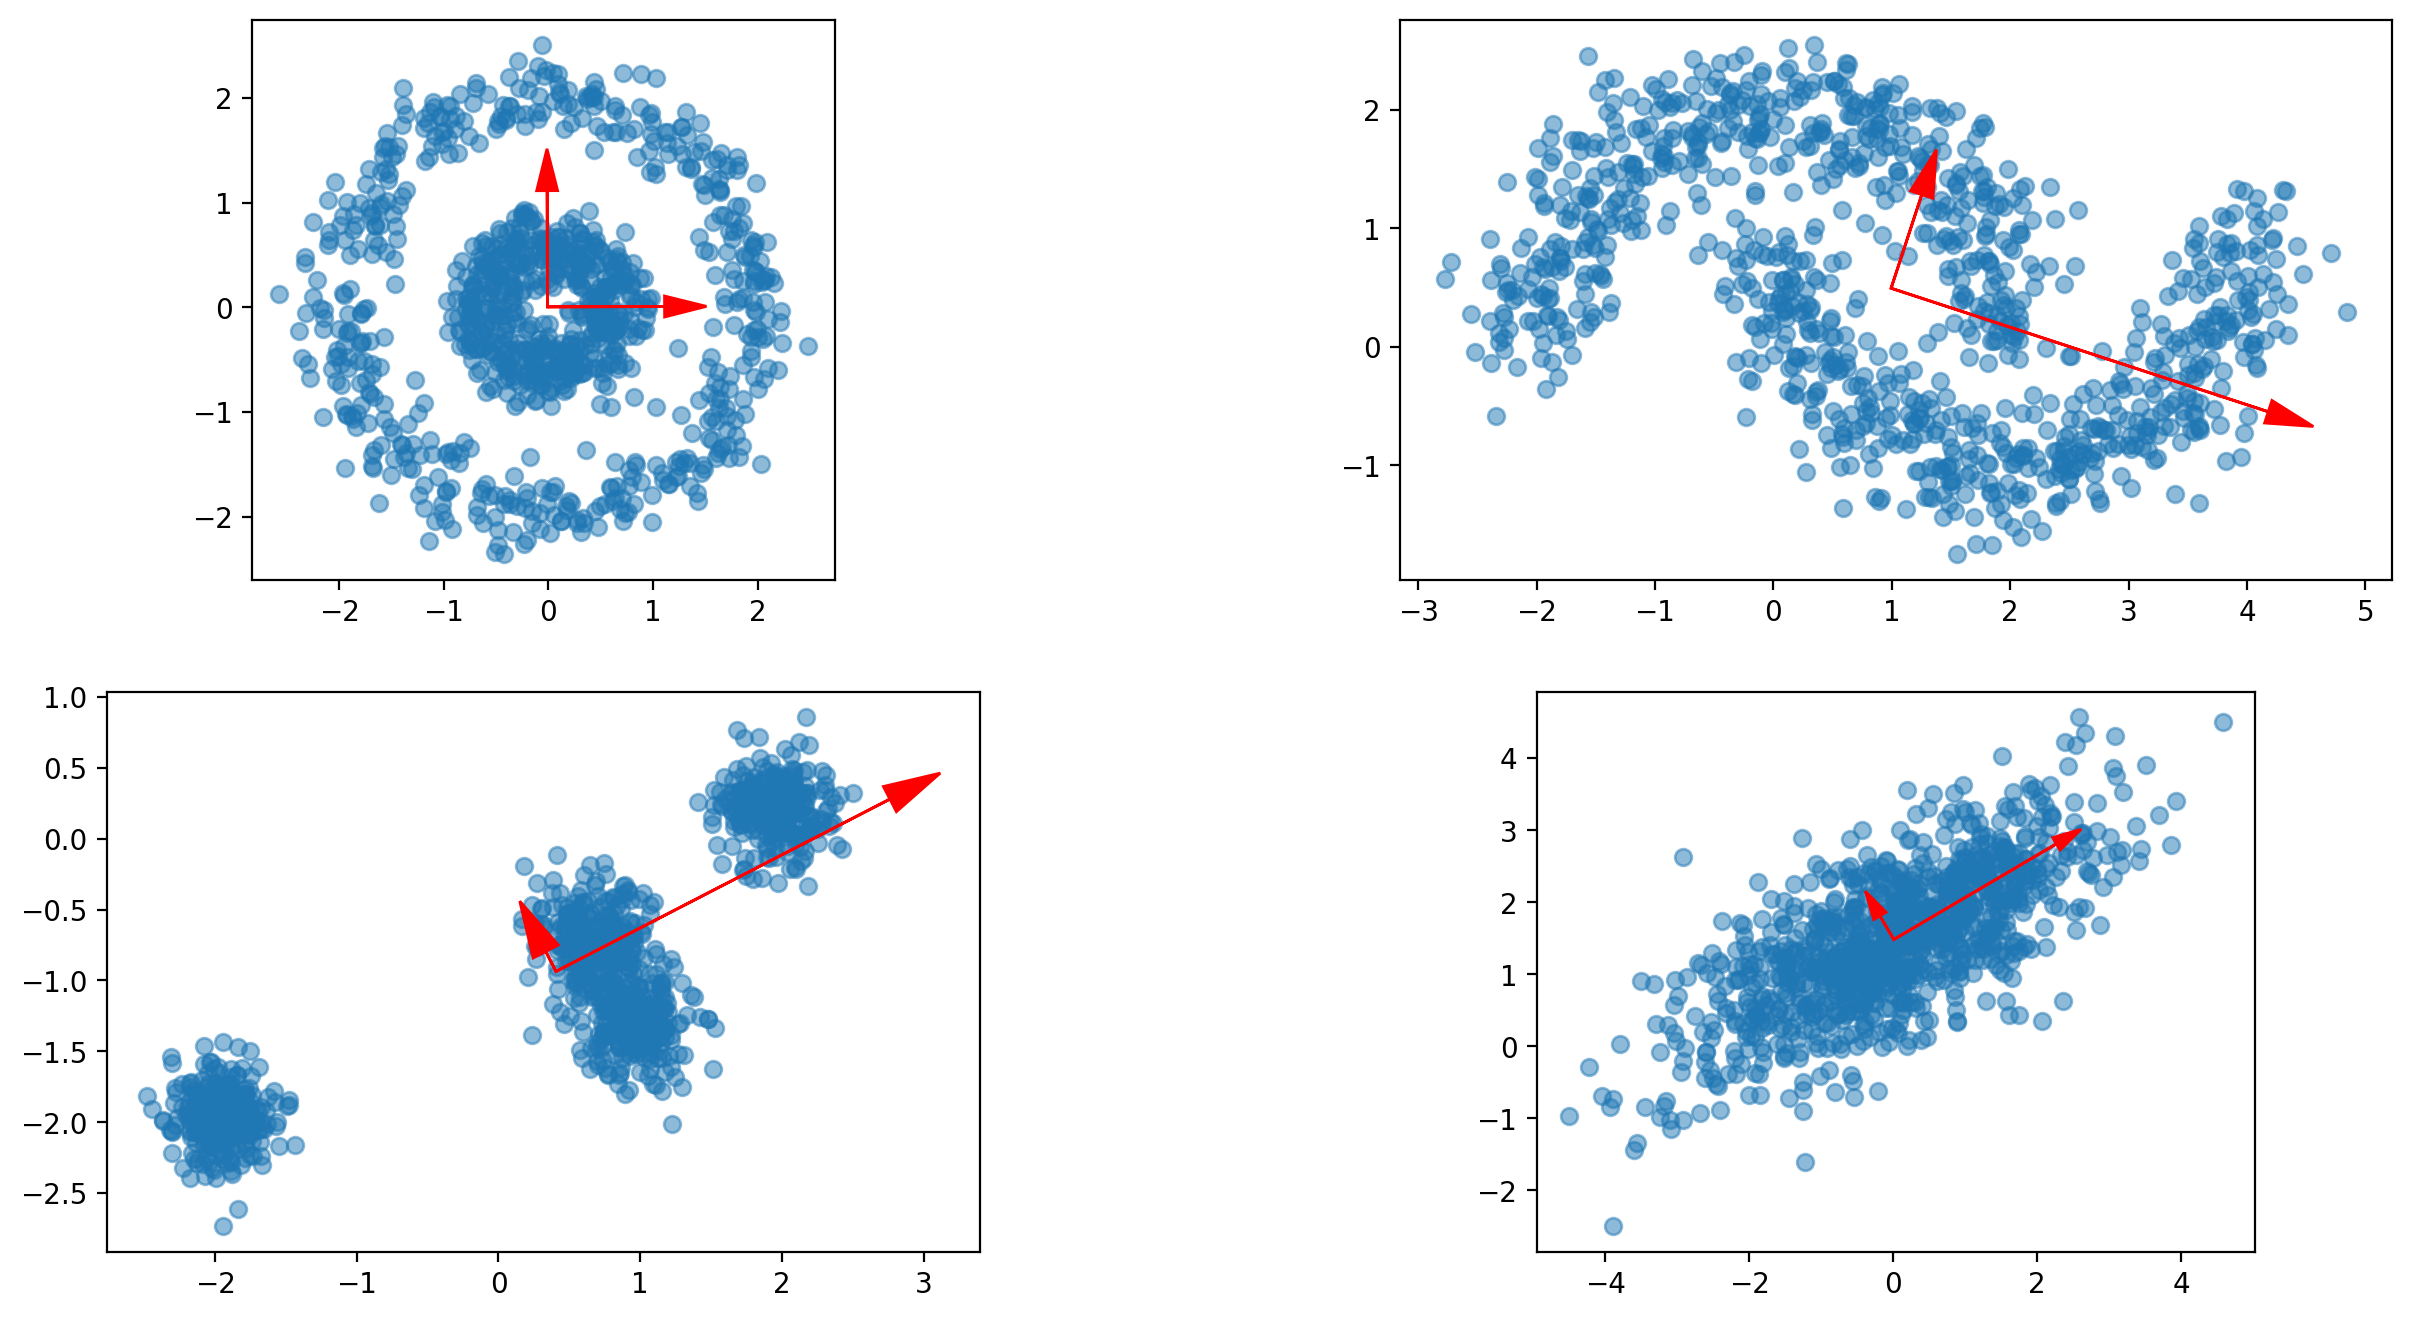

In [78]:
np.random.seed(228322) # поиграйте с сидами))

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.3, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.15)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5],
        cov=[[2, 1],
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

In [79]:
scaler = StandardScaler()


Доп.задание : Запустите предыдущий метод с учетом скейлинга. Поменяется ли результат?

In [80]:
pca = PCA(n_components = 5)
pipeline = Pipeline(steps=[('sc', scaler), ('pca',pca),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
pcas = " ".join(f"{i:.2}" for i in pca.explained_variance_ratio_)
print(f"Explained {pcas} ({pca.explained_variance_ratio_.sum():.2f}) ratio of variance")
# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_hat)
print('MAE: %.3f' % mae)

Explained 0.5 0.18 0.13 0.086 0.062 (0.95) ratio of variance
MAE: 0.272


Почему важно использование скейлинга перед проведением PCA?
Если один объект варьируется больше, чем другие, только из-за их соответствующих масштабов, PCA определит, что такой объект доминирует в направлении главных компонентов.

In [81]:
pca = PCA(n_components = 5)
pipeline = Pipeline(steps=[('pca',pca),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
pcas = " ".join(f"{i:.2}" for i in pca.explained_variance_ratio_)
print(f"Explained {pcas} ({pca.explained_variance_ratio_.sum():.2f}) ratio of variance")
# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_hat)
print('MAE: %.3f' % mae)

Explained 0.51 0.25 0.18 0.05 0.014 (1.00) ratio of variance
MAE: 0.274


 Какой метод наиболее страдает от проклятия размерности?
 KNN.

 Покажем это.

Рассмотрим набор MNIST - набор рукописных чисел от 0 до 9. Это один из классических наборов для компьютернорго зроения, состоящий из 100 тысяч черно-белых изображений 28х28. Однако матрицы можно и вытянуть в вектор, чтобы предсказывать класс в табличном формате. Тогда мы получим пространство признаков размера 784!

In [82]:
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float64')
X.reset_index()
y = mnist["target"].astype('int64')
y.reset_index()

print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


Так выглядит набор данных в табличном виде

In [83]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Рассмотрим случайный семпл в данных (преобразовав обратно в матрицу)

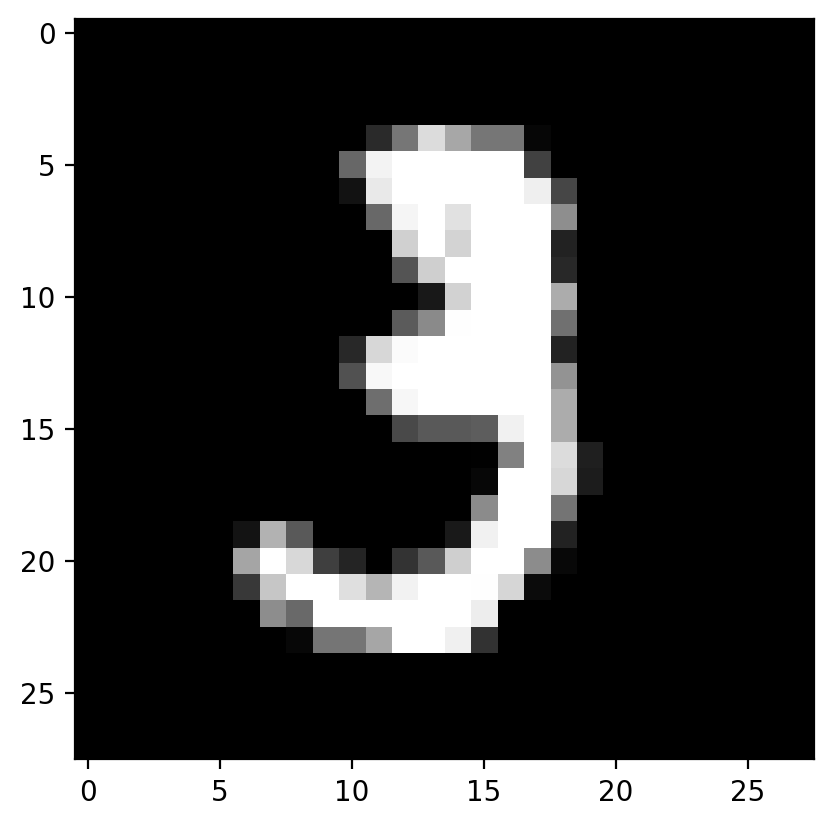

In [84]:
random_digit = X.loc[10,:].values

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()


Отнормируем

In [85]:
X /= 255.0


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Заодно с обучением модели вспомним о поиске гиперпараметров. Что это такое?

Так как данных очень много, равномерно засемплим 1000 точек. В общем случае это плохая практика. Почему?

In [87]:
random_indices = np.random.choice(X.index, 10000, replace=False)
X_rus = X.loc[random_indices]
y_rus = y.loc[random_indices]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=0)
print(X_train.shape, y_test.shape)

(8000, 784) (2000,)


In [ ]:
param_grid = {'n_neighbors': [3, 4], 'p': [2], 'weights': ["distance"]}


knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_
print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Score: 0.943875
Optimal Hyperparameter Values:  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}




In [100]:
%%time
knn = KNeighborsClassifier(**params_optimal_knn)

# Training the model with the best parameters
knn.fit(X_train, y_train)
y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0
CPU times: total: 6.77 s
Wall time: 551 ms


In [101]:
%%time

y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

CPU times: total: 8.41 s
Wall time: 671 ms


array([[804,   1,   2,   0,   1,   2,   5,   2,   0,   0],
       [  0, 874,   0,   0,   1,   0,   0,   1,   0,   1],
       [ 15,  16, 737,   3,   0,   2,   4,  22,   6,   3],
       [  1,   5,   2, 704,   0,  18,   2,  13,  12,   9],
       [  4,   6,   0,   0, 753,   0,   5,   3,   1,  31],
       [  5,   0,   1,  24,   0, 679,  15,   0,   3,   7],
       [  4,   5,   1,   0,   0,   7, 763,   0,   0,   1],
       [  0,  14,   3,   0,   4,   1,   0, 806,   1,   8],
       [  3,  12,   3,  15,   5,  19,   6,   6, 712,   8],
       [  3,   7,   0,  13,  19,   1,   0,  24,   2, 719]])

In [102]:

y_test_predicted = knn.predict(X_test)

test_accuracy_knn = np.mean(y_test_predicted == y_test)
print("\nTraining Accuracy: ", test_accuracy_knn)


Training Accuracy:  0.954


In [103]:
%%time

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))


# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.954

No. of correct predictions (Test): 1908/2000

Confusion Matrix (Test Data):
 [[179   0   0   0   0   0   0   0   0   0]
 [  0 233   0   1   0   0   0   0   0   0]
 [  2   8 179   3   0   0   0   3   2   0]
 [  1   3   2 209   0   3   0   1   3   4]
 [  0   0   0   0 165   0   0   0   0   4]
 [  0   0   1   3   1 177   1   0   1   2]
 [  1   0   0   0   0   0 185   0   0   0]
 [  0   5   0   0   1   0   0 216   0   2]
 [  1   4   0   3   0   5   1   0 181   3]
 [  2   0   1   4   2   0   0   7   1 184]]
CPU times: total: 4 s
Wall time: 300 ms


In [104]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,179,0,0,0,0,0,0,0,0,0,179
1,0,233,0,1,0,0,0,0,0,0,234
2,2,8,179,3,0,0,0,3,2,0,197
3,1,3,2,209,0,3,0,1,3,4,226
4,0,0,0,0,165,0,0,0,0,4,169
5,0,0,1,3,1,177,1,0,1,2,186
6,1,0,0,0,0,0,185,0,0,0,186
7,0,5,0,0,1,0,0,216,0,2,224
8,1,4,0,3,0,5,1,0,181,3,198


Попробуем уменьшить влияние проклятия размерности с помощью уменьшения размерности, использовав метод PCA.

In [105]:
%%time
pca = PCA(n_components=0.95)
pca.fit(X_train)

print("Number of Principle Components: ", pca.n_components_)

Number of Principle Components:  151
CPU times: total: 703 ms
Wall time: 130 ms


In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [107]:
%%time


knn_pca = KNeighborsClassifier(n_neighbors=4, p=2, weights="distance")

knn_pca.fit(X_train_pca, y_train)


y_test_predicted_pca_knn = knn_pca.predict(X_test_pca)
print("KNN (PCA): Test Accuracy: ", accuracy_score(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Classification Report:")
print(classification_report(y_test, y_test_predicted_pca_knn))

print("\n")

KNN (PCA): Test Accuracy:  0.957

KNN (PCA): Test Confusion Matrix:
[[179   0   0   0   0   0   0   0   0   0]
 [  0 233   0   1   0   0   0   0   0   0]
 [  2   7 181   3   0   0   0   2   2   0]
 [  0   3   2 211   0   3   0   1   3   3]
 [  0   0   0   0 165   0   0   0   0   4]
 [  0   0   1   3   1 177   1   0   1   2]
 [  1   0   0   0   0   0 185   0   0   0]
 [  1   4   0   0   1   0   0 216   0   2]
 [  1   3   0   4   0   4   1   0 182   3]
 [  2   0   1   4   3   0   0   5   1 185]]

KNN (PCA): Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       179
           1       0.93      1.00      0.96       234
           2       0.98      0.92      0.95       197
           3       0.93      0.93      0.93       226
           4       0.97      0.98      0.97       169
           5       0.96      0.95      0.96       186
           6       0.99      0.99      0.99       186
           7       0.96      0.96

Мы видим, что после уменьшения размерности мы можем снизить стоимость расчета расстояния в K-NN, что приводит к значительному сокращению времени обучения. При этом мы не потеряли в точности, а даже выиграли!

Для сравнения времени обучения рассмотрим метод, построенный не на расстоянии - случайный лес. Эта модель будет страдать от проклятия размерности в терминах времени меньше.

In [108]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train, y_train)

y_test_predicted_rf = forest_clf.predict(X_test)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.5s finished


Random Forest: Test Accuracy:  0.945

Random Forest: Test Confusion Matrix:
[[178   0   0   0   0   0   1   0   0   0]
 [  0 231   1   1   0   0   0   0   1   0]
 [  1   2 183   3   2   0   0   1   4   1]
 [  0   3   6 209   0   3   0   3   0   2]
 [  0   0   1   0 158   0   0   1   0   9]
 [  0   1   1   3   0 175   1   0   2   3]
 [  1   0   0   0   2   0 183   0   0   0]
 [  0   3   5   0   1   0   0 212   0   3]
 [  0   3   1   3   0   3   3   0 183   2]
 [  2   1   3   6   5   1   0   3   2 178]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       179
           1       0.95      0.99      0.97       234
           2       0.91      0.93      0.92       197
           3       0.93      0.92      0.93       226
           4       0.94      0.93      0.94       169
           5       0.96      0.94      0.95       186
           6       0.97      0.98      0.98       186
           7       0.

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [109]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train_pca, y_train)

y_test_predicted_rf = forest_clf.predict(X_test_pca)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.9s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Random Forest: Test Accuracy:  0.932

Random Forest: Test Confusion Matrix:
[[175   0   1   0   0   0   2   0   1   0]
 [  0 232   1   0   0   1   0   0   0   0]
 [  2   2 177   5   3   1   0   2   5   0]
 [  0   1   5 210   0   1   2   2   5   0]
 [  0   0   1   0 159   0   0   1   0   8]
 [  0   0   1   3   2 172   4   0   3   1]
 [  0   0   0   0   1   1 184   0   0   0]
 [  2   4   4   0   2   0   0 208   0   4]
 [  1   1   3   7   1   4   3   0 175   3]
 [  2   3   2   4   6   3   0   6   3 172]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       179
           1       0.95      0.99      0.97       234
           2       0.91      0.90      0.90       197
           3       0.92      0.93      0.92       226
           4       0.91      0.94      0.93       169
           5       0.94      0.92      0.93       186
           6       0.94      0.99      0.97       186
           7       0.

Как видно, обучение произошло гораздо быстрее, при этом точность алгоритма даже выше, чем у KNN

## Проиллюстрируем

In [110]:
def process_image(filename, size=64):
    with Image.open(filename) as img:
        # Convert to grayscale and resize
        img = img.convert('L').resize((size, size))
        
        # Convert to numpy array with channel dimension
        arr = np.array(img, dtype=np.uint8)[..., np.newaxis]
        return arr

Создадим небольшой датасет с картинками котов. Для простоты переведем ихз в черно-белую гамму и сделаем их размера 64 на 64. ПОсмотрим, что получится. При этом выведем еще и "среднего кота". Потом нам это понадобится для PCA.

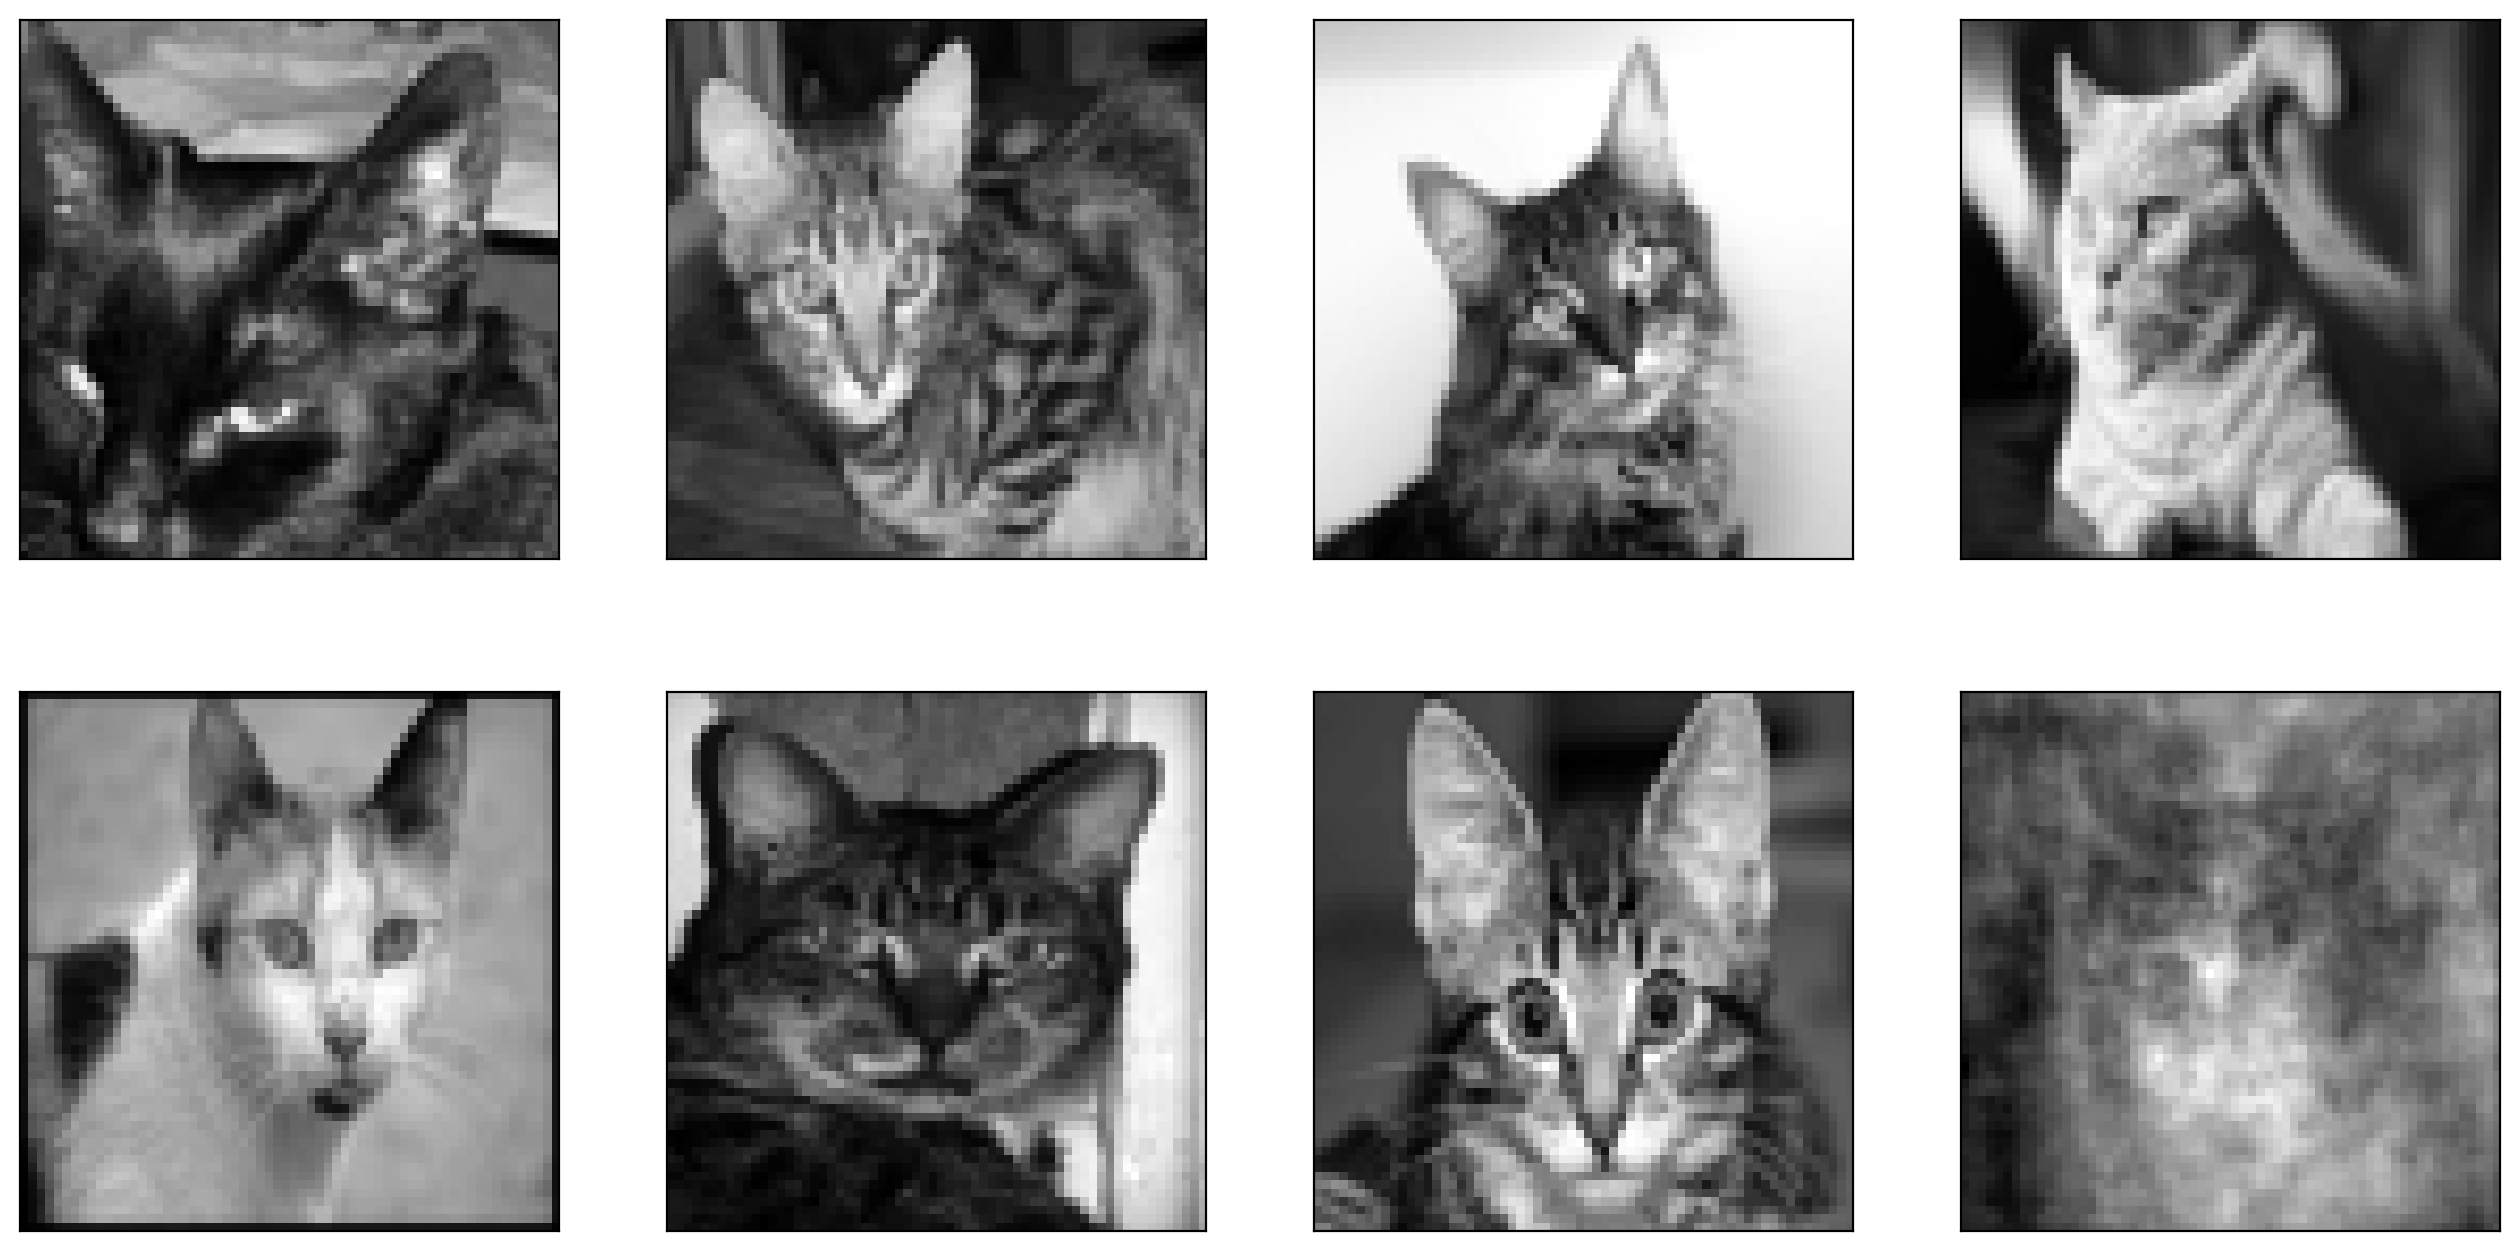

In [111]:
from PIL import Image
import random
random.seed(1234)
cats_path = os.path.join(data_path, "base_cats")
image_shape = (64, 64)
rows, cols = 2, 4
n_samples = rows * cols

all_files = [f for f in os.listdir(cats_path ) 
                if f.lower().endswith(('.jpg', '.jpeg'))]
processed = []
for filename in random.sample(all_files, 120):
    processed.append(process_image(os.path.join(cats_path, filename)))
    
sample = random.sample(processed, n_samples)
cats_data = np.array(processed, dtype=np.float32)

mean_cat = cats_data.mean(axis=0)

plt.figure(figsize=(16, 8))

for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cats_data[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_cat.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Применим к ним PCA. Найдем первые главные компоненты

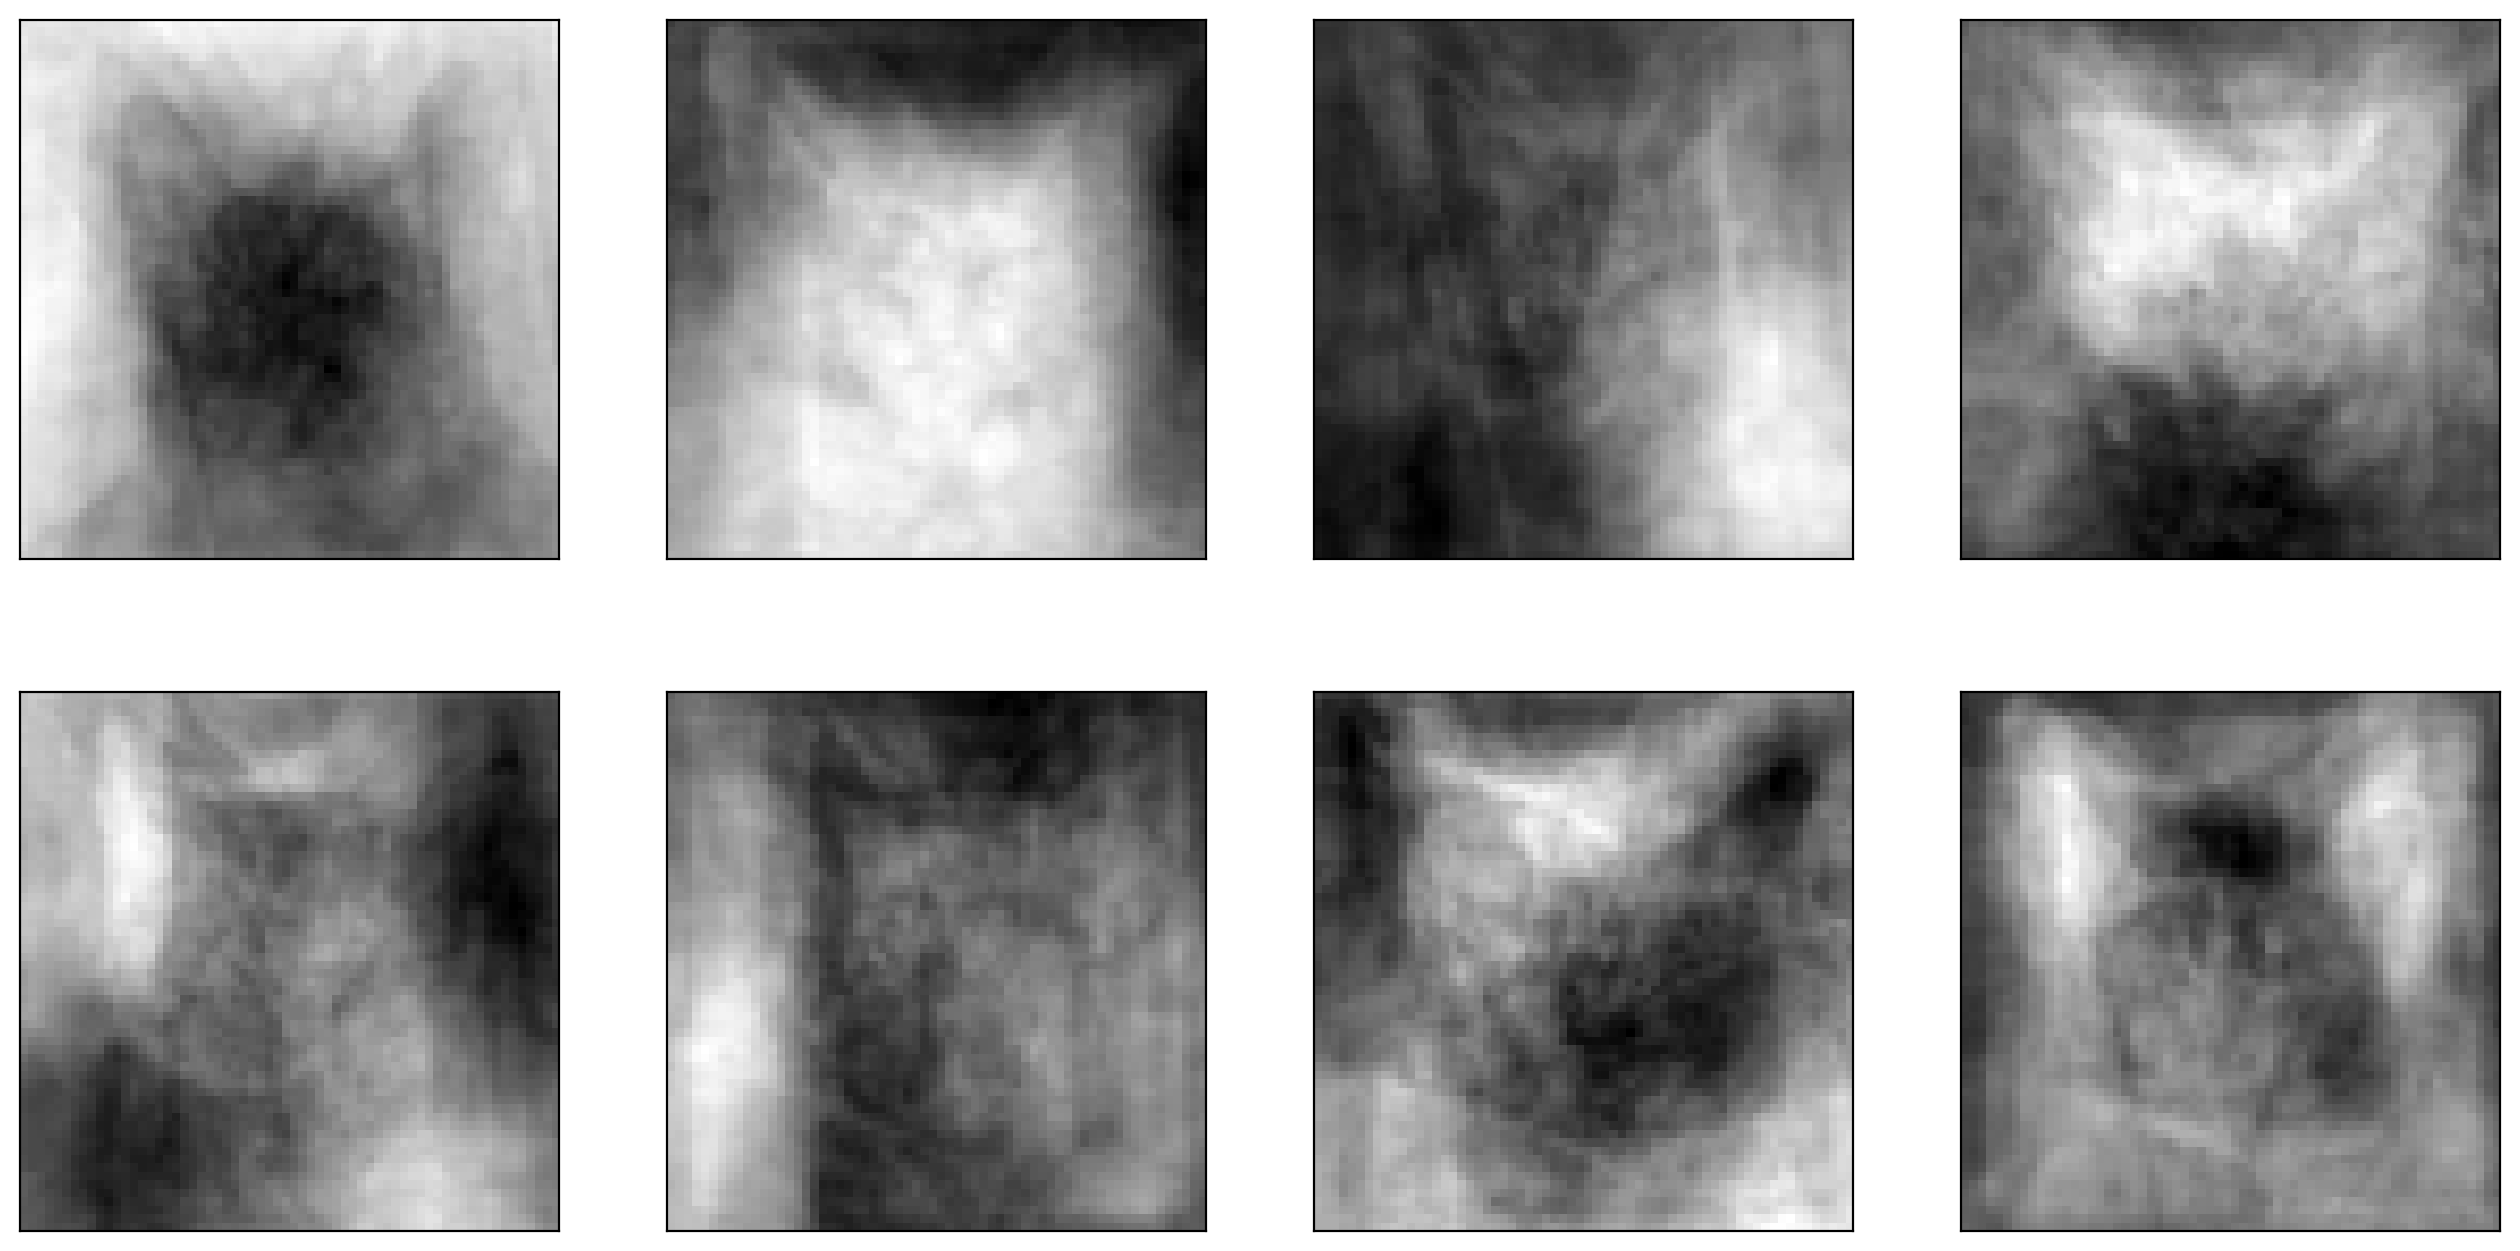

In [112]:
model_pca = PCA()
cats_data -= mean_cat  # отнормировали данные к нулевому среднему
model_pca.fit(cats_data.reshape(-1, 64*64))

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получились забавные призраки! Обратите внимание, что это не изображение котов, а именно компоненты - или собственные векторы $X^T X$.